# **Analysis of various Selection Strategies to solve Cold Start Problem with Twitter Sentiment Dataset**




# Setup

## Get Distil and Submodlib from Decile Repo

In [ ]:
# Get DISTIL
!git clone https://github.com/decile-team/distil.git

# Get submodlib
!git clone https://github.com/decile-team/submodlib.git

fatal: destination path 'distil' already exists and is not an empty directory.
fatal: destination path 'submodlib' already exists and is not an empty directory.


## Installations

#### *Restart runtime from here after initial install is complete*

In [ ]:
# Installations for DISTIL
!cd distil && pip install -r distil/requirements/requirements.txt
!pip install -r distil/requirements/requirements.txt

# Required installations
!pip install transformers
!pip install datasets

# Installations for Submodlib
!pip install -e ./submodlib/

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'distil/requirements/requirements.txt'
Looking in indexes: https://test.pypi.org/simple/, https://pypi.org/simple/
  Using cached sphinxcontrib_bibtex-2.6.2-py3-none-any.whl (40 kB)
  Using cached multipledispatch-0.6.0-py3-none-any.whl (11 kB)
  Using cached scikit-learn-0.23.0.tar.gz (7.2 MB)
  error: subprocess-exited-with-error
  
  × pip subprocess to install build dependencies did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing build dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install build dependencies did not run successfully.
│ exit code: 1
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.
Obtaining file:///content/submodlib
  Installing build dependencies ... done
  Checking if build

## Imports

In [ ]:
# Standard imports
import copy
import html
import math
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import os
import pandas as pd
import random # Import for query size sampling
import re # Import for baseline regex matching
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import statistics as stat
import string
import sys
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import unicodedata

# Imports for datasets
from collections import Counter
from datasets import Dataset as D
from datasets import load_dataset, load_metric, concatenate_datasets
from io import BytesIO
import requests
from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, ConcatDataset
from tqdm.auto import tqdm
import zipfile

# Additional Imports
from transformers import AutoTokenizer, get_scheduler, BertConfig, AdamW, BertModel

# Imports for active learning
sys.path.append('submodlib/')
sys.path.append('distil/')
from distil.active_learning_strategies import BADGE, SMI, EntropySampling, LeastConfidenceSampling, MarginSampling, RandomSampling, KMeansSampling  # All active learning strategies showcased in this example
from distil.utils.utils import LabeledToUnlabeledDataset # A utility wrapper class that removes labels from labeled PyTorch dataset objects

## Download GloVe vectorizer

In [ ]:
# Get a simple tokenizer from torchtext. Use GloVe embeddings from torchtext, which will automatically download them.
glove_tokenizer     = get_tokenizer("basic_english")
glove_vectorizer    = GloVe(name='6B', dim=300)

.vector_cache/glove.6B.zip: 862MB [02:39, 5.41MB/s]                           
100%|█████████▉| 399999/400000 [00:36<00:00, 10944.73it/s]


The above procedure should take 15-30 minutes. The rest of the code should run quicker.

# Data loading, sampling and pre-processing

## Load data from UCI_ML/Github Repository

In [ ]:
# URL of the CSV file containing the Tweet Sentiment Collection dataset
tweet_url = "https://raw.github.com/ayushbits/robust-aggregate-lfs/main/reef/data/twitter/Tweets.csv"

# Load the data, skipping bad lines
tweet_df = pd.read_csv(tweet_url, on_bad_lines='skip')

# Display tweet dataframe data
tweet_df.head(10)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,tweet_coord,tweet_created,tweet_location,user_timezone,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,5.703061e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,...,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
1,5.703011e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
2,5.703011e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
4,5.703008e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
5,5.703008e+17,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
6,5.703006e+17,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,...,NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
7,5.703002e+17,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
8,5.703000e+17,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,...,NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN
9,5.702955e+17,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,...,NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada),NaN,NaN,NaN,NaN,NaN,NaN


### Drop irrelevant columns and rename the sentiment column and labels

In [ ]:
# Rename the columns
tweet_df = tweet_df.rename(columns={'airline_sentiment': 'labels'})

# Keep only text and labels columns
tweet_df = tweet_df[['text', 'labels']]

# Replace 'positive' with 1 and 'negative' with 0 (we will not be using neutral sentiment)
tweet_df['labels'] = tweet_df['labels'].replace({'positive': 1, 'negative': 0})

In [ ]:
tweet_df.head(10)

,text,labels
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,1
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,0
4,@VirginAmerica and it's a really big bad thing...,0
5,@VirginAmerica seriously would pay $30 a fligh...,0
6,"@VirginAmerica yes, nearly every time I fly VX...",1
7,@VirginAmerica Really missed a prime opportuni...,neutral
8,"@virginamerica Well, I didn't…but NOW I DO! :-D",1
9,"@VirginAmerica it was amazing, and arrived an ...",1


In [ ]:
tweet_df['labels'].value_counts()

0          9087
neutral    3053
1          2338
Name: labels, dtype: int64

In [ ]:
len(tweet_df)

14478

### Discard neutral sentiment data points (Tweet Dataset only)

In [ ]:
# Retain only negative and positive points in tweet data
negative_df = tweet_df[tweet_df['labels']==0]
positive_df = tweet_df[tweet_df['labels']==1]
binary_df = pd.concat([negative_df, positive_df], ignore_index=True)

In [ ]:
print(negative_df.head())
print(positive_df.head())

                                                 text labels
3   @VirginAmerica it's really aggressive to blast...      0
4   @VirginAmerica and it's a really big bad thing...      0
5   @VirginAmerica seriously would pay $30 a fligh...      0
15      @VirginAmerica SFO-PDX schedule is still MIA.      0
17  @VirginAmerica  I flew from NYC to SFO last we...      0
                                                 text labels
1   @VirginAmerica plus you've added commercials t...      1
6   @VirginAmerica yes, nearly every time I fly VX...      1
8     @virginamerica Well, I didn't…but NOW I DO! :-D      1
9   @VirginAmerica it was amazing, and arrived an ...      1
11  @VirginAmerica I &lt;3 pretty graphics. so muc...      1


## Define data pre-processing

### Text pre-processing

In [ ]:
# NLTK Downloads
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# Set of punctuation special characters to remove from text
punctuation = set(string.punctuation)

# List of stopwords (commonly used words in English)
english_stopwords = set(stopwords.words('english'))

In [ ]:
# Converts all text to lowercase
def to_lower(text):
    return text.lower()

# Removes punctuation from the text
def remove_punc(text):
    return ''.join(x if x not in punctuation else ' ' for x in text)

# Decodes HTML entities and converts accented text to normal
def to_ascii(text):
    decoded_text = html.unescape(text)  # Decoding HTML entities
    return ''.join(x for x in unicodedata.normalize('NFD', decoded_text) if unicodedata.category(x) != 'Mn')

# Removes stopwords
def remove_stopwords(text):
    return ' '.join(x for x in word_tokenize(text) if x not in english_stopwords)

# Removes BOM Unicode
def remove_bom(text):
    return text.replace('\ufeff', '')

# Remove excess whitespace
def remove_xtra(text):
    return ' '.join(text.split()).strip()

# Process the data by making all text lowercase, removing puncuation, removing stopwords, and converting to ascii
def process_data(data):
    data['text'] = data['text'].apply(to_lower)
    data['text'] = data['text'].apply(to_ascii)
    data['text'] = data['text'].apply(remove_punc)
    data['text'] = data['text'].apply(remove_stopwords)
    data['text'] = data['text'].apply(remove_bom)
    data['text'] = data['text'].apply(remove_xtra)
    return data

### GloVe embeddings

In [ ]:
# Create a full dataset wrapper. This will return a dictionary of 3 items:
#   1. glove_embeddings:    The embedding vectors for the sentence, padded to the max length.
#   2. input_mask:          A tensor that denotes the start idx of the padded part of the sequence
#   3. labels:              A single-element tensor denoting the class.
#
# Creating such an object this way will allow us to utilize DISTIL's interfaces without issue and will also be compatible with the model defined above.
class FullDatasetWrapper(Dataset):

    # Here's how we can get embeddings for each sentence. This will create a list of tensors, which will have varying sizes.
    # We will need to pad each tensor for batching, so we will also need to keep track of the actual final token in each batch so that we do not compute on padded input.
    def __init__(self, datalist, labels):
        self.glove_embeddings   = [glove_vectorizer.get_vecs_by_tokens(glove_tokenizer(data_text), lower_case_backup=True) for data_text in datalist] # Convert text into glove embeddings
        self.labels             = torch.tensor(labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length


    def __init__(self, dataframe):
        self.glove_embeddings = []
        valid_labels = []
        for ind in dataframe.index:
            data_text, data_label = dataframe['text'][ind], dataframe['labels'][ind]
            tokens = glove_tokenizer(data_text)
            if not tokens:   # Check if token list is empty
                # print(f"Warning: No tokens for text: {data_text}")
                continue
            glove_embedding = glove_vectorizer.get_vecs_by_tokens(tokens, lower_case_backup=True)
            if glove_embedding.shape[0] == 0:  # Check if no embeddings found
                # print(f"Warning: No embeddings for tokens: {tokens} in text: {data_text}")
                continue
            self.glove_embeddings.append(glove_embedding)
            valid_labels.append(data_label)
        self.labels             = torch.tensor(valid_labels)
        self.pad_length         = max([glove_embedding.shape[0] for glove_embedding in self.glove_embeddings]) # Max sequence length

    def __getitem__(self, index):
        glove_embedding                                     = self.glove_embeddings[index]                              # Get the glove embeddings for sentence
        padded_glove_embedding                              = torch.zeros(self.pad_length, glove_embedding.shape[1])    # Create a padded tensor of zeros to hold them
        padded_glove_embedding[:glove_embedding.shape[0]]   = glove_embedding                                           # Populate the front of the tensor w/ glove embeddings
        input_mask                                          = torch.tensor(glove_embedding.shape[0])                    # Create a single-element tensor denoting index to start ignoring hidden states
        label                                               = self.labels[index]                                        # Get the label and form the dictionary.
        item_dict                                           =   {"glove_embeddings":    padded_glove_embedding,
                                                                "input_mask":           input_mask,
                                                                "labels":               label}
        return item_dict

    def __len__(self):
        return len(self.glove_embeddings)

### AL Label Removal

In [ ]:
class Labeled_to_unlabel(Dataset):

  def __init__(self, wrapped_dataset):
        self.wrapped_dataset = wrapped_dataset
        # give the words here

  def __getitem__(self, index):

        #label = self.wrapped_dataset[index]['labels']
        data = {key:self.wrapped_dataset[index][key] for key in self.wrapped_dataset[index] if key != 'labels'}

        #data = self.wrapped_dataset[index]
        return data

  def __len__(self):
        return len(self.wrapped_dataset)

## Data split and sampling

In [ ]:
seed_values = [42, 96, 35, 52, 11, 87, 26, 75, 60, 49]

#### *Use Ctrl+F10 from here for experiment re-runs (after changing exp_num)*

In [ ]:
exp_num = 10 # CHANGE ME

In [ ]:
# DEFINE RAND_STATE FOR EXPERIMENT RUN
RAND_STATE = seed_values[exp_num-1]
print('Experiment number: {} \tSeed value = {}'.format(exp_num, RAND_STATE))
with open('logs.txt', 'a') as logfile:
    logfile.write('\n\nExperiment number: {} \tSeed value = {}  [Tweet Data]\n'.format(exp_num, RAND_STATE))

Experiment number: 10 	Seed value = 49


### Create test-train split

In [ ]:
# Separate the dataset into two based on the labels
df_0 = binary_df[binary_df['labels'] == 0]
df_1 = binary_df[binary_df['labels'] == 1]

# Specify the features (X) and target (y) columns
X_0, y_0 = df_0['text'], df_0['labels']
X_1, y_1 = df_1['text'], df_1['labels']

# Perform the train-test split while varying the class distribution
X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X_0, y_0, test_size=0.1, random_state=RAND_STATE, stratify=y_0)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_1, y_1, test_size=0.4, random_state=RAND_STATE, stratify=y_1)

# Concatenate the train parts and test parts
X_train = pd.concat([X_train_0, X_train_1])
y_train = pd.concat([y_train_0, y_train_1])
X_test = pd.concat([X_test_0, X_test_1])
y_test = pd.concat([y_test_0, y_test_1])

# Create the train_df and test_df DataFrames
train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Shuffle the train and test dataframes
train_df = train_df.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)
test_df = test_df.sample(frac=1, random_state=RAND_STATE).reset_index(drop=True)

### Find data distribution and calculate imbalance factor

In [ ]:
print('\t  Negative     Positive')
train_class_counts = train_df['labels'].value_counts()
print('Training   ', train_class_counts[0], '\t', train_class_counts[1])
test_class_counts = test_df['labels'].value_counts()
print('Testing     ', test_class_counts[0], '\t ', test_class_counts[1])

	  Negative     Positive
Training    8178 	 1402
Testing      909 	  936


In [ ]:
print("Rare class to majority class ratio ~ 1 :", round(train_class_counts[0]/train_class_counts[1]))

Rare class to majority class ratio ~ 1 : 6


In [ ]:
a, b = len(test_df), len(train_df)
print("Effective test-train split = {}:{}".format(round((100*a)/(a+b)), round((100*b)/(a+b))))

Effective test-train split = 16:84


### Create query set

In [ ]:
# List of commonly found phrases in positive sentiment tweets
freq_twt_positive_phrases = [
    "Absolutely love", "Amazing job", "Can't wait for", "Extremely happy to",
    "Feeling blessed", "Feeling inspired by", "Feeling optimistic about",
    "Feeling very proud of", "Had a great time", "Highly recommend",
    "Incredible experience", "Overwhelmed with happiness", "Really excited about",
    "So grateful for", "Such a beautiful", "Thank you so much",
    "Totally loving the", "Truly amazing", "Very successful", "Wonderful day"
]
query_set_size = len(freq_twt_positive_phrases)
query_data = pd.DataFrame({
    'text':freq_twt_positive_phrases, 'labels': [1]*query_set_size
})

## Apply pre-processing

### Apply text processing

In [ ]:
train_processed_df = process_data(train_df)
# train_processed_df.iloc[10:25]
train_processed_df.head()

,text,labels
0,southwestair wrote customer support monday can...,0
1,united website says 10 days 16 counting,0
2,americanair trouble getting rebooked,0
3,united direct messaged hear anything back,0
4,jetblue mean take time write physical letter f...,0


In [ ]:
query_df = process_data(query_data)
query_df.head()

,text,labels
0,absolutely love,1
1,amazing job,1
2,wait,1
3,extremely happy,1
4,feeling blessed,1


In [ ]:
test_df = process_data(test_df)

### Get dataset with embeddings

In [ ]:
# GloVe Embeddings for Training Dataset
training_dataset = FullDatasetWrapper(train_processed_df)
# GloVe Embeddings for Query Datas
rare_class_query_set = FullDatasetWrapper(query_df)
# GloVe Embeddings for Testing Dataset
testing_dataset = FullDatasetWrapper(test_df)

# Custom LSTM Model

## Model Definition

In [ ]:
class Average(nn.Module):

    def __init__(self):
        super().__init__()

    def forward(self, batch_sentence_token_embeddings, input_mask):
        avgs = []
        with torch.no_grad():
            for i in range(batch_sentence_token_embeddings.shape[0]):
                avg = torch.mean(batch_sentence_token_embeddings[i,:input_mask[i],:], dim=0)
                avgs.append(avg)
        return torch.stack(avgs, dim=0)


class SimpleGloVeRNN(nn.Module):

    def __init__(self, num_classes, hidden_dim=512, embedding_dim=256, num_rnn_stacks=1, num_mlp_layers=1):

        super().__init__()
        self.average  = Average()
        self.rnn      = nn.LSTM(batch_first=True, input_size=300, hidden_size=hidden_dim, num_layers=num_rnn_stacks)
        self.activ    = nn.ReLU()

        mlp_layers  = []
        for i in range(num_mlp_layers - 1):
            linear      = nn.Linear(hidden_dim, hidden_dim)
            bn          = nn.BatchNorm1d(hidden_dim)
            mlp_layers.append(linear)
            mlp_layers.append(bn)
            mlp_layers.append(self.activ)
        embed_linear    = nn.Linear(hidden_dim, embedding_dim)
        embed_bn        = nn.BatchNorm1d(hidden_dim)
        mlp_layers.append(embed_linear)
        mlp_layers.append(embed_bn)

        self.mlp            = nn.Sequential(*mlp_layers)
        self.cls            = nn.Linear(embedding_dim, num_classes)
        self.embedding_dim  = embedding_dim
        self.hidden_dim     = hidden_dim


    def get_embedding_dim(self):
        return self.embedding_dim


    def forward(self, glove_embeddings, input_mask, labels=None, freeze=False, last=False):

        if freeze:
            with torch.no_grad():
                ignore_this         = self.average(glove_embeddings, input_mask)
                hidden_states, _    = self.rnn(glove_embeddings)
                # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
                last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
                if last_hidden_states.size(1) == 1:
                    last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
                else:
                    last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
                # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
                sentence_embed      = self.mlp(last_hidden_states)
        else:
            ignore_this         = self.average(glove_embeddings, input_mask)                                                            # Added so we can use hooks to get input values for DISTIL's SMI.
            hidden_states, _    = self.rnn(glove_embeddings)                                                                            # Apply RNN
            # last_hidden_states  = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1).squeeze()  # Using the mask, get the hidden vectors that correspond to the end of each sequence in the batch.
            last_hidden_states = torch.gather(hidden_states, 1, input_mask.reshape(-1,1,1).repeat(1,1,self.hidden_dim) - 1)
            if last_hidden_states.size(1) == 1:
                last_hidden_states = last_hidden_states.squeeze(1) # Squeeze the second dimension if it's 1
            else:
                last_hidden_states = last_hidden_states.squeeze() # Or just squeeze the last dimension
            # print(last_hidden_states.shape, glove_embeddings.shape, input_mask.shape)
            sentence_embed      = self.mlp(last_hidden_states)                                                                          # Then, apply the MLP on top of the hidden states.
        logits  = self.cls(self.activ(sentence_embed))
        if last:
            return logits, sentence_embed
        else:
            return logits

## Custom Training Method

In [ ]:
class data_train:

    def __init__(self, num_cls=2, hidden_dim=256, embedding_dim=256, num_rnn_stacks=2, mlp_layers=2, batch_size=20) -> None:
        self.model = SimpleGloVeRNN(num_cls, hidden_dim, embedding_dim, num_rnn_stacks, mlp_layers)
        self.num_cls = num_cls
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.num_rnn_stacks = num_rnn_stacks
        self.mlp_layers = mlp_layers
        self.batch_size = batch_size
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.model.to(self.device)

    def get_param_count(self):
        # How many parameters? Should be MUCH less than BERT (110 million)! Can configure above params to make the model larger/smaller.
        param_count = 0
        for param in self.model.parameters():
            size_list   = param.size()
            param_count += torch.prod(torch.tensor(size_list)).item()
        print("Parameters:", F"{param_count:,}")
        return param_count

    def check_batching(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output = self.model(**batch_dict)
            print(output.shape)

    def train(self, training_dataset, epochs=150, lr=1e-2):
        dataloader = DataLoader(training_dataset, batch_size=self.batch_size, shuffle=False)
        optimizer = optim.SGD(self.model.parameters(), lr=1e-2)
        self.model.train()
        losses = []
        for i in range(epochs):
            epoch_loss, num_batches = 0, 0
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                optimizer.zero_grad()
                out   = self.model(**batch_dict)
                loss  = torch.nn.functional.cross_entropy(out, batch_dict["labels"])
                loss.backward()
                optimizer.step()
                epoch_loss, num_batches = epoch_loss+loss.item(), num_batches+1
            avg_loss = epoch_loss/num_batches if num_batches>0 else 0
            if (i+1)%5==0:
                print('Epoch:', (i+1), '\tLoss =', avg_loss)
            losses.append(avg_loss)
        self.model.eval()
        return losses

    def verify_output_emeddings(self, training_dataset):
        dataloader = DataLoader(training_dataset, batch_size=2, shuffle=False)
        for batch_dict in dataloader:
            batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
            output, embeddings = self.model(**batch_dict, last=True, freeze=True)
            print(output)
            print(embeddings.shape)

    def get_test_metrics(self, testing_dataset):
        dataloader = DataLoader(testing_dataset, batch_size=self.batch_size, shuffle=False)
        # Initialize counters
        tp = fp = fn = tn = 0

        self.model.eval()
        with torch.no_grad():
            for batch_dict in dataloader:
                batch_dict = {k:v.to(self.device) for k,v in batch_dict.items()}
                # Get model outputs
                outputs = self.model(**batch_dict)
                # Calculate predictions from outputs (assuming binary classification with threshold at 0.5)
                # Modify the threshold and prediction calculation if necessary
                predictions = torch.argmax(outputs, dim=1)
                # Get true labels
                true_labels = batch_dict["labels"]
                # Update confusion matrix
                conf_mat = confusion_matrix(true_labels.cpu().numpy(), predictions.cpu().numpy(), labels=[0, 1])
                tn_, fp_, fn_, tp_ = conf_mat.ravel() if conf_mat.size == 4 else (0, 0, 0, 0)
                tp, fp, fn, tn = tp+tp_, fp+fp_, fn+fn_, tn+tn_

        acc = (tp + tn) / (tp + fp + fn + tn) if (tp + fp + fn + tn) > 0 else 0
        ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = (2 * tp) / (2 * tp + fp + fn) if (2 * tp + fp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (tp + fn) if (tp + fn) > 0 else 0
        tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
        npv = tn / (tn + fn) if (tn + fn) > 0 else 0
        fdr = fp / (tp + fp) if (tp + fp) > 0 else 0
        mcc_numerator = (tp * tn) - (fp * fn)
        mcc_denominator = ((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn)) ** 0.5
        mcc = mcc_numerator / mcc_denominator if mcc_denominator > 0 else 0

        metrics = {
            'tp': tp, 'fp': fp, 'fn': fn, 'tn': tn, 'acc': acc, 'f1': f1,
            'ppv': ppv, 'tpr': tpr, 'fpr': fpr, 'fnr': fnr,
            'tnr': tnr, 'npv': npv, 'fdr': fdr, 'mcc': mcc
        }

        return metrics


### Metric_dict Definition

In [ ]:
metric_dict = {
    'tp': "True Positive Count", 'fp': 'False Positive Count',
    'fn': "False Negative Count", 'tn': 'True Negative Count',
    'acc': "Accuracy", 'f1': 'F1-score | F-measure',
    'ppv': "Positive Predictive Value | Precision",
    'tpr': 'True Positive Rate | Recall | Sensitivity',
    'fpr': "False Positive Rate | Type I error",
    'fnr': 'False Negative Rate | Type II error',
    'tnr': "True Negative Rate | Specificity",
    'npv': 'Negative Predictive Value', 'fdr': "False Discovery Rate",
    'mcc': 'Matthews Correlation Coefficient',

}
metric_dict

{'tp': 'True Positive Count',
 'fp': 'False Positive Count',
 'fn': 'False Negative Count',
 'tn': 'True Negative Count',
 'acc': 'Accuracy',
 'f1': 'F1-score | F-measure',
 'ppv': 'Positive Predictive Value | Precision',
 'tpr': 'True Positive Rate | Recall | Sensitivity',
 'fpr': 'False Positive Rate | Type I error',
 'fnr': 'False Negative Rate | Type II error',
 'tnr': 'True Negative Rate | Specificity',
 'npv': 'Negative Predictive Value',
 'fdr': 'False Discovery Rate',
 'mcc': 'Matthews Correlation Coefficient'}

# Active Learning

## Define Selection Strategy arguments

In [ ]:
budget = round(sum(train_class_counts)/66.666) # Budget is set to 1.5% of the total training dataset
print(budget)

144


In [ ]:
selection_strategy_args = {
    'device':        "cpu",                  # Use the device used in training
    'batch_size':    20,                    # Use the batch size used in training
    'metric':        'cosine',             # Use cosine similarity when determining the likeness of two data points
    'optimizer':     'LazyGreedy',          # When doing submodular maximization, use the lazy greedy optimizer
    'embedding_type': 'features',          # IMPORTANT: NEED TO USE PRETRAINED GLOVE FEATURES FOR COLD START SELECTION!
    'layer_name':    'average'             # We can do so by specifying the layer we wish to extract those features from.
}

## Facility Location: Second variant (query-set Q)

In [ ]:
LSTM_fl2mi = data_train()

### FLQMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'fl2mi'
selection_strategy_args['device'] = LSTM_fl2mi.device
fl2mi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_fl2mi.model, LSTM_fl2mi.num_cls, selection_strategy_args)
fl2mi_selected_idx = fl2mi_selection_strategy.select(budget)
fl2mi_human_labeled_dataset = Subset(training_dataset, fl2mi_selected_idx)

fl2mi_class_counts = [0 for x in range(LSTM_fl2mi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in fl2mi_human_labeled_dataset:
    fl2mi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: FLQMI')
for class_idx, class_count in enumerate(fl2mi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: FLQMI
Class 0 count: 42
Class 1 count: 102


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: FLQMI \n')
    for class_idx, class_count in enumerate(fl2mi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on FLQMI Selection

In [ ]:
losses_fl2mi = LSTM_fl2mi.train(fl2mi_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.2333793342113495
Epoch: 10 	Loss = 0.1159631279297173
Epoch: 15 	Loss = 0.07057723333127797
Epoch: 20 	Loss = 0.048772746114991605
Epoch: 25 	Loss = 0.036612248863093555


### Test Performance - FLQMI

In [ ]:
fl2mi_metrics = LSTM_fl2mi.get_test_metrics(testing_dataset)

In [ ]:
fl2mi_metrics

{'tp': 829,
 'fp': 589,
 'fn': 107,
 'tn': 320,
 'acc': 0.6227642276422765,
 'f1': 0.7043330501274426,
 'ppv': 0.5846262341325811,
 'tpr': 0.8856837606837606,
 'fpr': 0.647964796479648,
 'fnr': 0.11431623931623931,
 'tnr': 0.35203520352035206,
 'npv': 0.7494145199063232,
 'fdr': 0.4153737658674189,
 'mcc': 0.2817939354423532}

In [ ]:
fl2mi_metrics['name'] = 'FLQMI'

## Facility Location: First variant (ground-set V)

In [ ]:
LSTM_fl1mi = data_train()

### FLVMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'fl1mi'
selection_strategy_args['device'] = LSTM_fl1mi.device
fl1mi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_fl1mi.model, LSTM_fl1mi.num_cls, selection_strategy_args)
fl1mi_selected_idx = fl1mi_selection_strategy.select(budget)
fl1mi_human_labeled_dataset = Subset(training_dataset, fl1mi_selected_idx)

fl1mi_class_counts = [0 for x in range(LSTM_fl1mi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in fl1mi_human_labeled_dataset:
    fl1mi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: FLVMI')
for class_idx, class_count in enumerate(fl1mi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: FLVMI
Class 0 count: 109
Class 1 count: 35


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: FLVMI \n')
    for class_idx, class_count in enumerate(fl1mi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on FLVMI Selection

In [ ]:
losses_fl1mi = LSTM_fl1mi.train(fl1mi_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.2629026025533676
Epoch: 10 	Loss = 0.1430423278361559
Epoch: 15 	Loss = 0.0883778054267168
Epoch: 20 	Loss = 0.06065382482483983
Epoch: 25 	Loss = 0.045030830428004265


### Test Performance - FLVMI

In [ ]:
fl1mi_metrics = LSTM_fl1mi.get_test_metrics(testing_dataset)

In [ ]:
fl1mi_metrics

{'tp': 286,
 'fp': 24,
 'fn': 650,
 'tn': 885,
 'acc': 0.6346883468834689,
 'f1': 0.4590690208667737,
 'ppv': 0.9225806451612903,
 'tpr': 0.3055555555555556,
 'fpr': 0.026402640264026403,
 'fnr': 0.6944444444444444,
 'tnr': 0.9735973597359736,
 'npv': 0.5765472312703583,
 'fdr': 0.07741935483870968,
 'mcc': 0.3732733607011956}

In [ ]:
fl1mi_metrics['name'] = 'FLVMI'

## Log Determinant

In [ ]:
LSTM_logdetmi = data_train()

### LogDetMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'logdetmi'
selection_strategy_args['device'] = LSTM_logdetmi.device
logdetmi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_logdetmi.model, LSTM_logdetmi.num_cls, selection_strategy_args)
logdetmi_selected_idx = logdetmi_selection_strategy.select(budget)
logdetmi_human_labeled_dataset = Subset(training_dataset, logdetmi_selected_idx)

logdetmi_class_counts = [0 for x in range(LSTM_logdetmi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in logdetmi_human_labeled_dataset:
    logdetmi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: LogDetMI')
for class_idx, class_count in enumerate(logdetmi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: LogDetMI
Class 0 count: 76
Class 1 count: 68


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: LogDetMI \n')
    for class_idx, class_count in enumerate(logdetmi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on LogDetMI Selection

In [ ]:
losses_logdetmi = LSTM_logdetmi.train(logdetmi_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.18119798926636577
Epoch: 10 	Loss = 0.07762523833662271
Epoch: 15 	Loss = 0.04407317703589797
Epoch: 20 	Loss = 0.029287064564414322
Epoch: 25 	Loss = 0.021447018021717668


### Test Performance - LogDetMI

In [ ]:
logdetmi_metrics = LSTM_logdetmi.get_test_metrics(testing_dataset)

In [ ]:
logdetmi_metrics

{'tp': 551,
 'fp': 113,
 'fn': 385,
 'tn': 796,
 'acc': 0.7300813008130081,
 'f1': 0.68875,
 'ppv': 0.8298192771084337,
 'tpr': 0.5886752136752137,
 'fpr': 0.12431243124312431,
 'fnr': 0.4113247863247863,
 'tnr': 0.8756875687568757,
 'npv': 0.6740050804403048,
 'fdr': 0.17018072289156627,
 'mcc': 0.4836913070630814}

In [ ]:
logdetmi_metrics['name'] = 'LogDetMI'

## Graph Cut

In [ ]:
LSTM_gcmi = data_train()

### GCMI Subset Selection

In [ ]:
selection_strategy_args['smi_function'] = 'gcmi'
selection_strategy_args['device'] = LSTM_gcmi.device
gcmi_selection_strategy = SMI(training_dataset,Labeled_to_unlabel(training_dataset), rare_class_query_set, LSTM_gcmi.model, LSTM_gcmi.num_cls, selection_strategy_args)
gcmi_selected_idx = gcmi_selection_strategy.select(budget)
gcmi_human_labeled_dataset = Subset(training_dataset, gcmi_selected_idx)

gcmi_class_counts = [0 for x in range(LSTM_gcmi.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in gcmi_human_labeled_dataset:
    gcmi_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: GCMI')
for class_idx, class_count in enumerate(gcmi_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: GCMI
Class 0 count: 80
Class 1 count: 64


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: GCMI \n')
    for class_idx, class_count in enumerate(gcmi_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on GCMI Selection

In [ ]:
losses_gcmi = LSTM_gcmi.train(gcmi_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.22091983631253242
Epoch: 10 	Loss = 0.09065205790102482
Epoch: 15 	Loss = 0.05050424439832568
Epoch: 20 	Loss = 0.03332214988768101
Epoch: 25 	Loss = 0.024222517851740122


### Test Performance - GCMI

In [ ]:
gcmi_metrics = LSTM_gcmi.get_test_metrics(testing_dataset)

In [ ]:
gcmi_metrics

{'tp': 706,
 'fp': 388,
 'fn': 230,
 'tn': 521,
 'acc': 0.6650406504065041,
 'f1': 0.6955665024630542,
 'ppv': 0.6453382084095064,
 'tpr': 0.7542735042735043,
 'fpr': 0.42684268426842686,
 'fnr': 0.24572649572649571,
 'tnr': 0.5731573157315731,
 'npv': 0.6937416777629827,
 'fdr': 0.3546617915904936,
 'mcc': 0.3332044495151384}

In [ ]:
gcmi_metrics['name'] = 'GCMI'

## RegEx Baseline

In [ ]:
LSTM_regex = data_train()

### Custom RegEx Sampling

In [ ]:
# Extract only the text (not labels) from the train_dataset after text processing
full_data_texts = train_processed_df['text'].tolist()
query_texts = query_df['text'].tolist()

# Function to count regex matches
def count_regex_matches(text, patterns):
    return sum([1 if re.search(pattern, text) else 0 for pattern in patterns])

# Count matches for each item in full_data_texts
match_counts = [count_regex_matches(text, query_texts) for text in full_data_texts]

# Extract the top k indices
regex_selected_idx = sorted(range(len(match_counts)), key=lambda i: match_counts[i], reverse=True)[:budget]
print(len(regex_selected_idx), regex_selected_idx[:budget//5])

144 [24, 33, 36, 46, 49, 95, 100, 160, 164, 185, 195, 240, 275, 281, 376, 401, 408, 415, 434, 450, 465, 485, 486, 504, 512, 518, 520, 525]


In [ ]:
regex_human_labeled_dataset = FullDatasetWrapper(train_processed_df.iloc[regex_selected_idx])
regex_class_counts = [0 for x in range(LSTM_regex.num_cls)] # Comment if repeating selection
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in regex_human_labeled_dataset:
    regex_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: RegEx Baseline')
for class_idx, class_count in enumerate(regex_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: RegEx Baseline
Class 0 count: 126
Class 1 count: 18


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: RegEx Baseline \n')
    for class_idx, class_count in enumerate(regex_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on RegEx Selection

In [ ]:
losses_regex = LSTM_regex.train(regex_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.1185136828571558
Epoch: 10 	Loss = 0.05606941320002079
Epoch: 15 	Loss = 0.034758291905745864
Epoch: 20 	Loss = 0.024565543979406357
Epoch: 25 	Loss = 0.01885995047632605


### Test Performance - RegEx

In [ ]:
regex_metrics = LSTM_regex.get_test_metrics(testing_dataset)

In [ ]:
regex_metrics

{'tp': 254,
 'fp': 17,
 'fn': 682,
 'tn': 892,
 'acc': 0.6211382113821138,
 'f1': 0.4208782104391052,
 'ppv': 0.9372693726937269,
 'tpr': 0.27136752136752135,
 'fpr': 0.0187018701870187,
 'fnr': 0.7286324786324786,
 'tnr': 0.9812981298129813,
 'npv': 0.5667090216010165,
 'fdr': 0.06273062730627306,
 'mcc': 0.3568445448306384}

In [ ]:
regex_metrics['name'] = 'RegEx'

## Random Strategy

In [ ]:
LSTM_random = data_train()

### Random Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_random.device
random_selection_strategy = RandomSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_random.model, LSTM_random.num_cls, selection_strategy_args)
random_selected_idx = random_selection_strategy.select(budget)
random_human_labeled_dataset = Subset(training_dataset, random_selected_idx)

random_class_counts = [0 for x in range(LSTM_random.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in random_human_labeled_dataset:
    random_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Random')
for class_idx, class_count in enumerate(random_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Random
Class 0 count: 119
Class 1 count: 25


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Random \n')
    for class_idx, class_count in enumerate(random_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Random Selection

In [ ]:
losses_random = LSTM_random.train(random_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.15029058884829283
Epoch: 10 	Loss = 0.06952171865850687
Epoch: 15 	Loss = 0.04070220817811787
Epoch: 20 	Loss = 0.027609258191660047
Epoch: 25 	Loss = 0.020440438529476523


### Test Performance - Random

In [ ]:
random_metrics = LSTM_random.get_test_metrics(testing_dataset)

In [ ]:
random_metrics

{'tp': 279,
 'fp': 23,
 'fn': 657,
 'tn': 886,
 'acc': 0.6314363143631436,
 'f1': 0.4507269789983845,
 'ppv': 0.9238410596026491,
 'tpr': 0.2980769230769231,
 'fpr': 0.025302530253025302,
 'fnr': 0.7019230769230769,
 'tnr': 0.9746974697469747,
 'npv': 0.5742060920285159,
 'fdr': 0.076158940397351,
 'mcc': 0.3685844670952138}

In [ ]:
random_metrics['name'] = 'Random'

## BADGE - Batch Active learning by Diverse Gradient Embeddings

In [ ]:
LSTM_badge = data_train()

### BADGE Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_badge.device
badge_selection_strategy = BADGE(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_badge.model, LSTM_badge.num_cls, selection_strategy_args)
badge_selected_idx = badge_selection_strategy.select(budget)
badge_human_labeled_dataset = Subset(training_dataset, badge_selected_idx)

badge_class_counts = [0 for x in range(LSTM_badge.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in badge_human_labeled_dataset:
    badge_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: BADGE')
for class_idx, class_count in enumerate(badge_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: BADGE
Class 0 count: 123
Class 1 count: 21


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: BADGE \n')
    for class_idx, class_count in enumerate(badge_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on BADGE Selection

In [ ]:
losses_badge = LSTM_badge.train(badge_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.15842606034129858
Epoch: 10 	Loss = 0.07315362663939595
Epoch: 15 	Loss = 0.04343408718705177
Epoch: 20 	Loss = 0.029591629281640053
Epoch: 25 	Loss = 0.021927132504060864


### Test Performance - BADGE

In [ ]:
badge_metrics = LSTM_badge.get_test_metrics(testing_dataset)

In [ ]:
badge_metrics

{'tp': 98,
 'fp': 6,
 'fn': 838,
 'tn': 903,
 'acc': 0.5425474254742547,
 'f1': 0.18846153846153846,
 'ppv': 0.9423076923076923,
 'tpr': 0.1047008547008547,
 'fpr': 0.006600660066006601,
 'fnr': 0.8952991452991453,
 'tnr': 0.9933993399339934,
 'npv': 0.5186674325100517,
 'fdr': 0.057692307692307696,
 'mcc': 0.21265406054539399}

In [ ]:
badge_metrics['name'] = 'BADGE'

## Entropy Sampling

In [ ]:
LSTM_entropy = data_train()

### Entropy Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_entropy.device
entropy_selection_strategy = EntropySampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_entropy.model, LSTM_entropy.num_cls, selection_strategy_args)
entropy_selected_idx = entropy_selection_strategy.select(budget)
entropy_human_labeled_dataset = Subset(training_dataset, entropy_selected_idx)

entropy_class_counts = [0 for x in range(LSTM_entropy.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in entropy_human_labeled_dataset:
    entropy_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Entropy')
for class_idx, class_count in enumerate(entropy_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Entropy
Class 0 count: 126
Class 1 count: 18


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Entropy \n')
    for class_idx, class_count in enumerate(entropy_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Entropy Selection

In [ ]:
losses_entropy = LSTM_entropy.train(entropy_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.12534229084849358
Epoch: 10 	Loss = 0.05743420263752341
Epoch: 15 	Loss = 0.034663369646295905
Epoch: 20 	Loss = 0.024086739867925644
Epoch: 25 	Loss = 0.01814236829522997


### Test Performance - Entropy

In [ ]:
entropy_metrics = LSTM_entropy.get_test_metrics(testing_dataset)

In [ ]:
entropy_metrics

{'tp': 68,
 'fp': 1,
 'fn': 868,
 'tn': 908,
 'acc': 0.5289972899728997,
 'f1': 0.13532338308457711,
 'ppv': 0.9855072463768116,
 'tpr': 0.07264957264957266,
 'fpr': 0.0011001100110011,
 'fnr': 0.9273504273504274,
 'tnr': 0.9988998899889989,
 'npv': 0.5112612612612613,
 'fdr': 0.014492753623188406,
 'mcc': 0.18852989093846428}

In [ ]:
entropy_metrics['name'] = 'Entropy'

## Least Confidence Sampling

In [ ]:
LSTM_leastconf = data_train()

### Least Confidence Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_leastconf.device
leastconf_selection_strategy = LeastConfidenceSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_leastconf.model, LSTM_leastconf.num_cls, selection_strategy_args)
leastconf_selected_idx = leastconf_selection_strategy.select(budget)
leastconf_human_labeled_dataset = Subset(training_dataset, leastconf_selected_idx)

leastconf_class_counts = [0 for x in range(LSTM_leastconf.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in leastconf_human_labeled_dataset:
    leastconf_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Least Confidence')
for class_idx, class_count in enumerate(leastconf_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Least Confidence
Class 0 count: 115
Class 1 count: 29


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Least Confidence \n')
    for class_idx, class_count in enumerate(leastconf_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Least Confidence Selection

In [ ]:
losses_leastconf = LSTM_leastconf.train(leastconf_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.14377382304519415
Epoch: 10 	Loss = 0.0630059065297246
Epoch: 15 	Loss = 0.03686838201247156
Epoch: 20 	Loss = 0.025122328370343894
Epoch: 25 	Loss = 0.018771161732729524


### Test Performance - Least Confidence

In [ ]:
leastconf_metrics = LSTM_leastconf.get_test_metrics(testing_dataset)

In [ ]:
leastconf_metrics

{'tp': 62,
 'fp': 4,
 'fn': 874,
 'tn': 905,
 'acc': 0.5241192411924119,
 'f1': 0.12375249500998003,
 'ppv': 0.9393939393939394,
 'tpr': 0.06623931623931624,
 'fpr': 0.0044004400440044,
 'fnr': 0.9337606837606838,
 'tnr': 0.9955995599559956,
 'npv': 0.5087127599775154,
 'fdr': 0.06060606060606061,
 'mcc': 0.1664644547785539}

In [ ]:
leastconf_metrics['name'] = 'Least_Conf'

## Margin Sampling

In [ ]:
LSTM_margin = data_train()

### Margin Subset Selection

In [ ]:
selection_strategy_args['device'] = LSTM_margin.device
margin_selection_strategy = MarginSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_margin.model, LSTM_margin.num_cls, selection_strategy_args)
margin_selected_idx = margin_selection_strategy.select(budget)
margin_human_labeled_dataset = Subset(training_dataset, margin_selected_idx)

margin_class_counts = [0 for x in range(LSTM_margin.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in margin_human_labeled_dataset:
    margin_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: Margin')
for class_idx, class_count in enumerate(margin_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: Margin
Class 0 count: 130
Class 1 count: 14


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: Margin \n')
    for class_idx, class_count in enumerate(margin_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on Margin Selection

In [ ]:
losses_margin = LSTM_margin.train(margin_human_labeled_dataset, epochs=25)

Epoch: 5 	Loss = 0.12001384049654007
Epoch: 10 	Loss = 0.05722595052793622
Epoch: 15 	Loss = 0.03451296710409224
Epoch: 20 	Loss = 0.02391172864008695
Epoch: 25 	Loss = 0.0179777069715783


### Test Performance - Margin

In [ ]:
margin_metrics = LSTM_margin.get_test_metrics(testing_dataset)

In [ ]:
margin_metrics

{'tp': 109,
 'fp': 5,
 'fn': 827,
 'tn': 904,
 'acc': 0.5490514905149051,
 'f1': 0.20761904761904762,
 'ppv': 0.956140350877193,
 'tpr': 0.11645299145299146,
 'fpr': 0.005500550055005501,
 'fnr': 0.8835470085470085,
 'tnr': 0.9944994499449945,
 'npv': 0.5222414789139226,
 'fdr': 0.043859649122807015,
 'mcc': 0.23038583275835353}

In [ ]:
margin_metrics['name'] = 'Margin'

## KMeans Sampling

In [ ]:
LSTM_kmeans = data_train()

### KMeans Subset Selection

In [ ]:
selection_strategy_args['device']         = LSTM_kmeans.device
selection_strategy_args['representation'] = "raw"

# Get average glove embeddings of all unlabeled points, which can be done via the model
dummy_strategy      = MarginSampling(training_dataset,Labeled_to_unlabel(training_dataset), LSTM_kmeans.model, LSTM_kmeans.num_cls, selection_strategy_args)
extracted_features  = dummy_strategy.get_feature_embedding(Labeled_to_unlabel(training_dataset), True, layer_name='average')

class TensorDataset(Dataset):
    def __init__(self, feature_tensor):
        self.feature_tensor = feature_tensor


    def __getitem__(self, index):
        return self.feature_tensor[index]


    def __len__(self):
        return self.feature_tensor.shape[0]

sel_dataset = TensorDataset(extracted_features)
kmeans_selection_strategy = KMeansSampling(sel_dataset, sel_dataset, LSTM_kmeans.model, LSTM_kmeans.num_cls, selection_strategy_args)
kmeans_selected_idx = kmeans_selection_strategy.select(budget)
kmeans_human_labeled_dataset = Subset(training_dataset, kmeans_selected_idx)

kmeans_class_counts = [0 for x in range(LSTM_kmeans.num_cls)]
# Go over the newly labeled dataset, tallying the number of points seen in each class.
for _ in kmeans_human_labeled_dataset:
    kmeans_class_counts[_['labels']] += 1

# Print each class count
print('Active Learning Strategy: KMeans')
for class_idx, class_count in enumerate(kmeans_class_counts):
    print(F"Class {class_idx} count: {class_count}")

Active Learning Strategy: KMeans
Class 0 count: 119
Class 1 count: 25


In [ ]:
with open('logs.txt', 'a') as logfile:
    logfile.write('\nActive Learning Strategy: KMeans \n')
    for class_idx, class_count in enumerate(kmeans_class_counts):
        logfile.write(F"Class {class_idx} count: {class_count} \n")

### Training on KMeans Selection

In [ ]:
losses_kmeans = LSTM_kmeans.train(kmeans_human_labeled_dataset, epochs=30)

Epoch: 5 	Loss = 0.14843594562262297
Epoch: 10 	Loss = 0.0723919877782464
Epoch: 15 	Loss = 0.04327547550201416
Epoch: 20 	Loss = 0.02944325585849583
Epoch: 25 	Loss = 0.02172050904482603
Epoch: 30 	Loss = 0.016962011461146176


### Test Performance - KMeans

In [ ]:
kmeans_metrics = LSTM_kmeans.get_test_metrics(testing_dataset)

In [ ]:
kmeans_metrics

{'tp': 185,
 'fp': 18,
 'fn': 751,
 'tn': 891,
 'acc': 0.5831978319783198,
 'f1': 0.32484635645302895,
 'ppv': 0.9113300492610837,
 'tpr': 0.19764957264957264,
 'fpr': 0.019801980198019802,
 'fnr': 0.8023504273504274,
 'tnr': 0.9801980198019802,
 'npv': 0.5426309378806333,
 'fdr': 0.08866995073891626,
 'mcc': 0.28414057899230927}

In [ ]:
kmeans_metrics['name'] = 'KMeans'

# Experiment Results

## Graph - Training Losses

In [ ]:
def plot_multiple_losses(loss_dict):
    plt.figure(figsize=(16, 6))
    for strat,losses in loss_dict.items():
        plt.plot(losses, label=strat)
    plt.title('Training Losses for different Selection Strategies: Exp {} [Tweet Data]'.format(exp_num))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

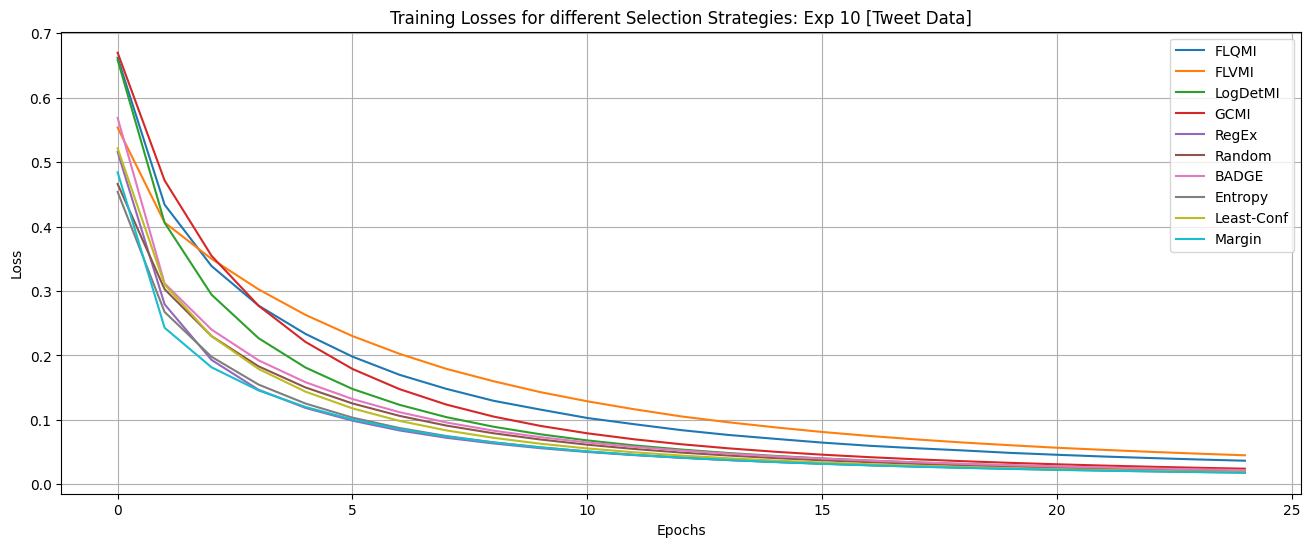

In [ ]:
plot_multiple_losses({
    'FLQMI': losses_fl2mi, 'FLVMI': losses_fl1mi,
    'LogDetMI': losses_logdetmi, 'GCMI': losses_gcmi,
    'RegEx': losses_regex, 'Random': losses_random,
    'BADGE': losses_badge, 'Entropy': losses_entropy,
    'Least-Conf': losses_leastconf, 'Margin': losses_margin
})

## Metric Compilation

In [ ]:
metric_list = [fl2mi_metrics, fl1mi_metrics, logdetmi_metrics, gcmi_metrics,
               regex_metrics, random_metrics, badge_metrics,
               entropy_metrics, leastconf_metrics, margin_metrics]

In [ ]:
metrics_compiled = {k: {
    metric['name']: metric[k] for metric in metric_list
    } for k in metric_list[0] if (k!='name')}
metrics_compiled

{'tp': {'FLQMI': 829,
  'FLVMI': 286,
  'LogDetMI': 551,
  'GCMI': 706,
  'RegEx': 254,
  'Random': 279,
  'BADGE': 98,
  'Entropy': 68,
  'Least_Conf': 62,
  'Margin': 109},
 'fp': {'FLQMI': 589,
  'FLVMI': 24,
  'LogDetMI': 113,
  'GCMI': 388,
  'RegEx': 17,
  'Random': 23,
  'BADGE': 6,
  'Entropy': 1,
  'Least_Conf': 4,
  'Margin': 5},
 'fn': {'FLQMI': 107,
  'FLVMI': 650,
  'LogDetMI': 385,
  'GCMI': 230,
  'RegEx': 682,
  'Random': 657,
  'BADGE': 838,
  'Entropy': 868,
  'Least_Conf': 874,
  'Margin': 827},
 'tn': {'FLQMI': 320,
  'FLVMI': 885,
  'LogDetMI': 796,
  'GCMI': 521,
  'RegEx': 892,
  'Random': 886,
  'BADGE': 903,
  'Entropy': 908,
  'Least_Conf': 905,
  'Margin': 904},
 'acc': {'FLQMI': 0.6227642276422765,
  'FLVMI': 0.6346883468834689,
  'LogDetMI': 0.7300813008130081,
  'GCMI': 0.6650406504065041,
  'RegEx': 0.6211382113821138,
  'Random': 0.6314363143631436,
  'BADGE': 0.5425474254742547,
  'Entropy': 0.5289972899728997,
  'Least_Conf': 0.5241192411924119,
  'Mar

In [ ]:
with open('logs.txt', 'a') as tf:
    tf.write('\n\nExp{}_metrics'.format(exp_num))
    tf.write(' = {')
    for k in metric_list[0]:
        if (k!='name'):
            tf.write("'{}': ".format(k))
            tf.write('{')
            for metric in metric_list[:-1]:
                tf.write("'{}': {}, ".format(metric['name'], round(metric[k], 5)))
            tf.write("'{}': {}".format(metric_list[-1]['name'], round(metric_list[-1][k], 5)))
            tf.write('}, ')

with open('logs.txt', 'r') as tf:
    contents = tf.read()
contents = contents[:-2]
with open('logs.txt', 'w') as tf:
    tf.write(contents)
    tf.write('}')


NOTE: Execute only till here for each experimental run. After each run, copy metrics generated in above output cell or output txt file and paste in the below cell for the respective experiment. After completing all 10 experiments, run below cells only by uncommenting to generate mean metrics and performance graphs.

## Overall Metric Stats

In [ ]:
def get_stats(values):
    return {'range': (min(values), max(values)), 'avg': round(sum(values)/len(values), 5), 'std_dev': round(stat.stdev(values), 5)}

In [ ]:
def end_of_exp():
    Exp1_metrics = {'tp': {'FLQMI': 619, 'FLVMI': 422, 'LogDetMI': 487, 'GCMI': 590, 'RegEx': 233, 'Random': 170, 'BADGE': 129, 'Entropy': 127, 'Least_Conf': 0, 'Margin': 6}, 'fp': {'FLQMI': 218, 'FLVMI': 48, 'LogDetMI': 102, 'GCMI': 204, 'RegEx': 21, 'Random': 11, 'BADGE': 4, 'Entropy': 3, 'Least_Conf': 1, 'Margin': 3}, 'fn': {'FLQMI': 317, 'FLVMI': 514, 'LogDetMI': 449, 'GCMI': 346, 'RegEx': 703, 'Random': 766, 'BADGE': 807, 'Entropy': 809, 'Least_Conf': 936, 'Margin': 930}, 'tn': {'FLQMI': 691, 'FLVMI': 861, 'LogDetMI': 807, 'GCMI': 705, 'RegEx': 888, 'Random': 898, 'BADGE': 905, 'Entropy': 906, 'Least_Conf': 908, 'Margin': 906}, 'acc': {'FLQMI': 0.71003, 'FLVMI': 0.69539, 'LogDetMI': 0.70136, 'GCMI': 0.7019, 'RegEx': 0.60759, 'Random': 0.57886, 'BADGE': 0.56043, 'Entropy': 0.55989, 'Least_Conf': 0.49214, 'Margin': 0.49431}, 'f1': {'FLQMI': 0.69825, 'FLVMI': 0.60028, 'LogDetMI': 0.63869, 'GCMI': 0.68208, 'RegEx': 0.3916, 'Random': 0.30439, 'BADGE': 0.24135, 'Entropy': 0.23827, 'Least_Conf': 0.0, 'Margin': 0.0127}, 'ppv': {'FLQMI': 0.73955, 'FLVMI': 0.89787, 'LogDetMI': 0.82683, 'GCMI': 0.74307, 'RegEx': 0.91732, 'Random': 0.93923, 'BADGE': 0.96992, 'Entropy': 0.97692, 'Least_Conf': 0.0, 'Margin': 0.66667}, 'tpr': {'FLQMI': 0.66132, 'FLVMI': 0.45085, 'LogDetMI': 0.5203, 'GCMI': 0.63034, 'RegEx': 0.24893, 'Random': 0.18162, 'BADGE': 0.13782, 'Entropy': 0.13568, 'Least_Conf': 0.0, 'Margin': 0.00641}, 'fpr': {'FLQMI': 0.23982, 'FLVMI': 0.05281, 'LogDetMI': 0.11221, 'GCMI': 0.22442, 'RegEx': 0.0231, 'Random': 0.0121, 'BADGE': 0.0044, 'Entropy': 0.0033, 'Least_Conf': 0.0011, 'Margin': 0.0033}, 'fnr': {'FLQMI': 0.33868, 'FLVMI': 0.54915, 'LogDetMI': 0.4797, 'GCMI': 0.36966, 'RegEx': 0.75107, 'Random': 0.81838, 'BADGE': 0.86218, 'Entropy': 0.86432, 'Least_Conf': 1.0, 'Margin': 0.99359}, 'tnr': {'FLQMI': 0.76018, 'FLVMI': 0.94719, 'LogDetMI': 0.88779, 'GCMI': 0.77558, 'RegEx': 0.9769, 'Random': 0.9879, 'BADGE': 0.9956, 'Entropy': 0.9967, 'Least_Conf': 0.9989, 'Margin': 0.9967}, 'npv': {'FLQMI': 0.68552, 'FLVMI': 0.62618, 'LogDetMI': 0.64252, 'GCMI': 0.67079, 'RegEx': 0.55814, 'Random': 0.53966, 'BADGE': 0.52862, 'Entropy': 0.52828, 'Least_Conf': 0.49241, 'Margin': 0.49346}, 'fdr': {'FLQMI': 0.26045, 'FLVMI': 0.10213, 'LogDetMI': 0.17317, 'GCMI': 0.25693, 'RegEx': 0.08268, 'Random': 0.06077, 'BADGE': 0.03008, 'Entropy': 0.02308, 'Least_Conf': 1.0, 'Margin': 0.33333}, 'mcc': {'FLQMI': 0.42328, 'FLVMI': 0.45673, 'LogDetMI': 0.43764, 'GCMI': 0.40987, 'RegEx': 0.32768, 'Random': 0.28493, 'BADGE': 0.25791, 'Entropy': 0.25861, 'Least_Conf': -0.02363, 'Margin': 0.02232}}
    Exp2_metrics = {'tp': {'FLQMI': 826, 'FLVMI': 354, 'LogDetMI': 577, 'GCMI': 672, 'RegEx': 137, 'Random': 90, 'BADGE': 287, 'Entropy': 0, 'Least_Conf': 101, 'Margin': 330}, 'fp': {'FLQMI': 495, 'FLVMI': 45, 'LogDetMI': 165, 'GCMI': 300, 'RegEx': 10, 'Random': 3, 'BADGE': 48, 'Entropy': 0, 'Least_Conf': 16, 'Margin': 63}, 'fn': {'FLQMI': 110, 'FLVMI': 582, 'LogDetMI': 359, 'GCMI': 264, 'RegEx': 799, 'Random': 846, 'BADGE': 649, 'Entropy': 936, 'Least_Conf': 835, 'Margin': 606}, 'tn': {'FLQMI': 414, 'FLVMI': 864, 'LogDetMI': 744, 'GCMI': 609, 'RegEx': 899, 'Random': 906, 'BADGE': 861, 'Entropy': 909, 'Least_Conf': 893, 'Margin': 846}, 'acc': {'FLQMI': 0.67209, 'FLVMI': 0.66016, 'LogDetMI': 0.71599, 'GCMI': 0.69431, 'RegEx': 0.56152, 'Random': 0.53984, 'BADGE': 0.62222, 'Entropy': 0.49268, 'Least_Conf': 0.53875, 'Margin': 0.6374}, 'f1': {'FLQMI': 0.73195, 'FLVMI': 0.53034, 'LogDetMI': 0.68772, 'GCMI': 0.7044, 'RegEx': 0.253, 'Random': 0.17493, 'BADGE': 0.45161, 'Entropy': 0.0, 'Least_Conf': 0.19183, 'Margin': 0.49661}, 'ppv': {'FLQMI': 0.62528, 'FLVMI': 0.88722, 'LogDetMI': 0.77763, 'GCMI': 0.69136, 'RegEx': 0.93197, 'Random': 0.96774, 'BADGE': 0.85672, 'Entropy': 0, 'Least_Conf': 0.86325, 'Margin': 0.83969}, 'tpr': {'FLQMI': 0.88248, 'FLVMI': 0.37821, 'LogDetMI': 0.61645, 'GCMI': 0.71795, 'RegEx': 0.14637, 'Random': 0.09615, 'BADGE': 0.30662, 'Entropy': 0.0, 'Least_Conf': 0.10791, 'Margin': 0.35256}, 'fpr': {'FLQMI': 0.54455, 'FLVMI': 0.0495, 'LogDetMI': 0.18152, 'GCMI': 0.33003, 'RegEx': 0.011, 'Random': 0.0033, 'BADGE': 0.05281, 'Entropy': 0.0, 'Least_Conf': 0.0176, 'Margin': 0.06931}, 'fnr': {'FLQMI': 0.11752, 'FLVMI': 0.62179, 'LogDetMI': 0.38355, 'GCMI': 0.28205, 'RegEx': 0.85363, 'Random': 0.90385, 'BADGE': 0.69338, 'Entropy': 1.0, 'Least_Conf': 0.89209, 'Margin': 0.64744}, 'tnr': {'FLQMI': 0.45545, 'FLVMI': 0.9505, 'LogDetMI': 0.81848, 'GCMI': 0.66997, 'RegEx': 0.989, 'Random': 0.9967, 'BADGE': 0.94719, 'Entropy': 1.0, 'Least_Conf': 0.9824, 'Margin': 0.93069}, 'npv': {'FLQMI': 0.79008, 'FLVMI': 0.59751, 'LogDetMI': 0.67452, 'GCMI': 0.69759, 'RegEx': 0.52945, 'Random': 0.51712, 'BADGE': 0.5702, 'Entropy': 0.49268, 'Least_Conf': 0.51678, 'Margin': 0.58264}, 'fdr': {'FLQMI': 0.37472, 'FLVMI': 0.11278, 'LogDetMI': 0.22237, 'GCMI': 0.30864, 'RegEx': 0.06803, 'Random': 0.03226, 'BADGE': 0.14328, 'Entropy': 0, 'Least_Conf': 0.13675, 'Margin': 0.16031}, 'mcc': {'FLQMI': 0.37465, 'FLVMI': 0.39916, 'LogDetMI': 0.44346, 'GCMI': 0.38843, 'RegEx': 0.24992, 'Random': 0.21218, 'BADGE': 0.32918, 'Entropy': 0, 'Least_Conf': 0.18525, 'Margin': 0.34588}}
    Exp3_metrics = {'tp': {'FLQMI': 768, 'FLVMI': 387, 'LogDetMI': 503, 'GCMI': 593, 'RegEx': 123, 'Random': 201, 'BADGE': 244, 'Entropy': 215, 'Least_Conf': 0, 'Margin': 104}, 'fp': {'FLQMI': 381, 'FLVMI': 69, 'LogDetMI': 63, 'GCMI': 242, 'RegEx': 1, 'Random': 12, 'BADGE': 13, 'Entropy': 28, 'Least_Conf': 0, 'Margin': 6}, 'fn': {'FLQMI': 168, 'FLVMI': 549, 'LogDetMI': 433, 'GCMI': 343, 'RegEx': 813, 'Random': 735, 'BADGE': 692, 'Entropy': 721, 'Least_Conf': 936, 'Margin': 832}, 'tn': {'FLQMI': 528, 'FLVMI': 840, 'LogDetMI': 846, 'GCMI': 667, 'RegEx': 908, 'Random': 897, 'BADGE': 896, 'Entropy': 881, 'Least_Conf': 909, 'Margin': 903}, 'acc': {'FLQMI': 0.70244, 'FLVMI': 0.66504, 'LogDetMI': 0.73117, 'GCMI': 0.68293, 'RegEx': 0.55881, 'Random': 0.59512, 'BADGE': 0.61789, 'Entropy': 0.59404, 'Least_Conf': 0.49268, 'Margin': 0.5458}, 'f1': {'FLQMI': 0.73669, 'FLVMI': 0.55603, 'LogDetMI': 0.66977, 'GCMI': 0.66968, 'RegEx': 0.23208, 'Random': 0.34987, 'BADGE': 0.40905, 'Entropy': 0.36472, 'Least_Conf': 0.0, 'Margin': 0.19885}, 'ppv': {'FLQMI': 0.66841, 'FLVMI': 0.84868, 'LogDetMI': 0.88869, 'GCMI': 0.71018, 'RegEx': 0.99194, 'Random': 0.94366, 'BADGE': 0.94942, 'Entropy': 0.88477, 'Least_Conf': 0, 'Margin': 0.94545}, 'tpr': {'FLQMI': 0.82051, 'FLVMI': 0.41346, 'LogDetMI': 0.53739, 'GCMI': 0.63355, 'RegEx': 0.13141, 'Random': 0.21474, 'BADGE': 0.26068, 'Entropy': 0.2297, 'Least_Conf': 0.0, 'Margin': 0.11111}, 'fpr': {'FLQMI': 0.41914, 'FLVMI': 0.07591, 'LogDetMI': 0.06931, 'GCMI': 0.26623, 'RegEx': 0.0011, 'Random': 0.0132, 'BADGE': 0.0143, 'Entropy': 0.0308, 'Least_Conf': 0.0, 'Margin': 0.0066}, 'fnr': {'FLQMI': 0.17949, 'FLVMI': 0.58654, 'LogDetMI': 0.46261, 'GCMI': 0.36645, 'RegEx': 0.86859, 'Random': 0.78526, 'BADGE': 0.73932, 'Entropy': 0.7703, 'Least_Conf': 1.0, 'Margin': 0.88889}, 'tnr': {'FLQMI': 0.58086, 'FLVMI': 0.92409, 'LogDetMI': 0.93069, 'GCMI': 0.73377, 'RegEx': 0.9989, 'Random': 0.9868, 'BADGE': 0.9857, 'Entropy': 0.9692, 'Least_Conf': 1.0, 'Margin': 0.9934}, 'npv': {'FLQMI': 0.75862, 'FLVMI': 0.60475, 'LogDetMI': 0.66145, 'GCMI': 0.6604, 'RegEx': 0.5276, 'Random': 0.54963, 'BADGE': 0.56423, 'Entropy': 0.54994, 'Least_Conf': 0.49268, 'Margin': 0.52046}, 'fdr': {'FLQMI': 0.33159, 'FLVMI': 0.15132, 'LogDetMI': 0.11131, 'GCMI': 0.28982, 'RegEx': 0.00806, 'Random': 0.05634, 'BADGE': 0.05058, 'Entropy': 0.11523, 'Least_Conf': 0, 'Margin': 0.05455}, 'mcc': {'FLQMI': 0.414, 'FLVMI': 0.39123, 'LogDetMI': 0.50746, 'GCMI': 0.36894, 'RegEx': 0.26019, 'Random': 0.31531, 'BADGE': 0.35574, 'Entropy': 0.29405, 'Least_Conf': 0, 'Margin': 0.22067}}
    Exp4_metrics = {'tp': {'FLQMI': 816, 'FLVMI': 481, 'LogDetMI': 613, 'GCMI': 741, 'RegEx': 2, 'Random': 261, 'BADGE': 87, 'Entropy': 31, 'Least_Conf': 50, 'Margin': 77}, 'fp': {'FLQMI': 501, 'FLVMI': 82, 'LogDetMI': 134, 'GCMI': 509, 'RegEx': 2, 'Random': 6, 'BADGE': 2, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 1}, 'fn': {'FLQMI': 120, 'FLVMI': 455, 'LogDetMI': 323, 'GCMI': 195, 'RegEx': 934, 'Random': 675, 'BADGE': 849, 'Entropy': 905, 'Least_Conf': 886, 'Margin': 859}, 'tn': {'FLQMI': 408, 'FLVMI': 827, 'LogDetMI': 775, 'GCMI': 400, 'RegEx': 907, 'Random': 903, 'BADGE': 907, 'Entropy': 909, 'Least_Conf': 909, 'Margin': 908}, 'acc': {'FLQMI': 0.66341, 'FLVMI': 0.70894, 'LogDetMI': 0.7523, 'GCMI': 0.61843, 'RegEx': 0.49268, 'Random': 0.63089, 'BADGE': 0.53875, 'Entropy': 0.50949, 'Least_Conf': 0.51978, 'Margin': 0.53388}, 'f1': {'FLQMI': 0.72437, 'FLVMI': 0.64176, 'LogDetMI': 0.72846, 'GCMI': 0.67795, 'RegEx': 0.00426, 'Random': 0.43392, 'BADGE': 0.16976, 'Entropy': 0.06412, 'Least_Conf': 0.10142, 'Margin': 0.15187}, 'ppv': {'FLQMI': 0.61959, 'FLVMI': 0.85435, 'LogDetMI': 0.82062, 'GCMI': 0.5928, 'RegEx': 0.5, 'Random': 0.97753, 'BADGE': 0.97753, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.98718}, 'tpr': {'FLQMI': 0.87179, 'FLVMI': 0.51389, 'LogDetMI': 0.65491, 'GCMI': 0.79167, 'RegEx': 0.00214, 'Random': 0.27885, 'BADGE': 0.09295, 'Entropy': 0.03312, 'Least_Conf': 0.05342, 'Margin': 0.08226}, 'fpr': {'FLQMI': 0.55116, 'FLVMI': 0.09021, 'LogDetMI': 0.14741, 'GCMI': 0.55996, 'RegEx': 0.0022, 'Random': 0.0066, 'BADGE': 0.0022, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.0011}, 'fnr': {'FLQMI': 0.12821, 'FLVMI': 0.48611, 'LogDetMI': 0.34509, 'GCMI': 0.20833, 'RegEx': 0.99786, 'Random': 0.72115, 'BADGE': 0.90705, 'Entropy': 0.96688, 'Least_Conf': 0.94658, 'Margin': 0.91774}, 'tnr': {'FLQMI': 0.44884, 'FLVMI': 0.90979, 'LogDetMI': 0.85259, 'GCMI': 0.44004, 'RegEx': 0.9978, 'Random': 0.9934, 'BADGE': 0.9978, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 0.9989}, 'npv': {'FLQMI': 0.77273, 'FLVMI': 0.64509, 'LogDetMI': 0.70583, 'GCMI': 0.67227, 'RegEx': 0.49267, 'Random': 0.57224, 'BADGE': 0.51651, 'Entropy': 0.5011, 'Least_Conf': 0.50641, 'Margin': 0.51387}, 'fdr': {'FLQMI': 0.38041, 'FLVMI': 0.14565, 'LogDetMI': 0.17938, 'GCMI': 0.4072, 'RegEx': 0.5, 'Random': 0.02247, 'BADGE': 0.02247, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.01282}, 'mcc': {'FLQMI': 0.35467, 'FLVMI': 0.46, 'LogDetMI': 0.51689, 'GCMI': 0.24783, 'RegEx': -0.00068, 'Random': 0.38688, 'BADGE': 0.21174, 'Entropy': 0.12883, 'Least_Conf': 0.16447, 'Margin': 0.20166}}
    Exp5_metrics = {'tp': {'FLQMI': 793, 'FLVMI': 432, 'LogDetMI': 458, 'GCMI': 841, 'RegEx': 215, 'Random': 151, 'BADGE': 98, 'Entropy': 0, 'Least_Conf': 442, 'Margin': 59}, 'fp': {'FLQMI': 436, 'FLVMI': 50, 'LogDetMI': 76, 'GCMI': 651, 'RegEx': 16, 'Random': 1, 'BADGE': 3, 'Entropy': 0, 'Least_Conf': 123, 'Margin': 1}, 'fn': {'FLQMI': 143, 'FLVMI': 504, 'LogDetMI': 478, 'GCMI': 95, 'RegEx': 721, 'Random': 785, 'BADGE': 838, 'Entropy': 936, 'Least_Conf': 494, 'Margin': 877}, 'tn': {'FLQMI': 473, 'FLVMI': 859, 'LogDetMI': 833, 'GCMI': 258, 'RegEx': 893, 'Random': 908, 'BADGE': 906, 'Entropy': 909, 'Least_Conf': 786, 'Margin': 908}, 'acc': {'FLQMI': 0.68618, 'FLVMI': 0.69973, 'LogDetMI': 0.69973, 'GCMI': 0.59566, 'RegEx': 0.60054, 'Random': 0.57398, 'BADGE': 0.54417, 'Entropy': 0.49268, 'Least_Conf': 0.66558, 'Margin': 0.52412}, 'f1': {'FLQMI': 0.73256, 'FLVMI': 0.60931, 'LogDetMI': 0.62313, 'GCMI': 0.69275, 'RegEx': 0.36847, 'Random': 0.27757, 'BADGE': 0.18901, 'Entropy': 0.0, 'Least_Conf': 0.58894, 'Margin': 0.11847}, 'ppv': {'FLQMI': 0.64524, 'FLVMI': 0.89627, 'LogDetMI': 0.85768, 'GCMI': 0.56367, 'RegEx': 0.93074, 'Random': 0.99342, 'BADGE': 0.9703, 'Entropy': 0, 'Least_Conf': 0.7823, 'Margin': 0.98333}, 'tpr': {'FLQMI': 0.84722, 'FLVMI': 0.46154, 'LogDetMI': 0.48932, 'GCMI': 0.8985, 'RegEx': 0.2297, 'Random': 0.16132, 'BADGE': 0.1047, 'Entropy': 0.0, 'Least_Conf': 0.47222, 'Margin': 0.06303}, 'fpr': {'FLQMI': 0.47965, 'FLVMI': 0.05501, 'LogDetMI': 0.08361, 'GCMI': 0.71617, 'RegEx': 0.0176, 'Random': 0.0011, 'BADGE': 0.0033, 'Entropy': 0.0, 'Least_Conf': 0.13531, 'Margin': 0.0011}, 'fnr': {'FLQMI': 0.15278, 'FLVMI': 0.53846, 'LogDetMI': 0.51068, 'GCMI': 0.1015, 'RegEx': 0.7703, 'Random': 0.83868, 'BADGE': 0.8953, 'Entropy': 1.0, 'Least_Conf': 0.52778, 'Margin': 0.93697}, 'tnr': {'FLQMI': 0.52035, 'FLVMI': 0.94499, 'LogDetMI': 0.91639, 'GCMI': 0.28383, 'RegEx': 0.9824, 'Random': 0.9989, 'BADGE': 0.9967, 'Entropy': 1.0, 'Least_Conf': 0.86469, 'Margin': 0.9989}, 'npv': {'FLQMI': 0.76786, 'FLVMI': 0.63023, 'LogDetMI': 0.63539, 'GCMI': 0.73088, 'RegEx': 0.55328, 'Random': 0.53633, 'BADGE': 0.5195, 'Entropy': 0.49268, 'Least_Conf': 0.61406, 'Margin': 0.50868}, 'fdr': {'FLQMI': 0.35476, 'FLVMI': 0.10373, 'LogDetMI': 0.14232, 'GCMI': 0.43633, 'RegEx': 0.06926, 'Random': 0.00658, 'BADGE': 0.0297, 'Entropy': 0, 'Least_Conf': 0.2177, 'Margin': 0.01667}, 'mcc': {'FLQMI': 0.38967, 'FLVMI': 0.46264, 'LogDetMI': 0.44726, 'GCMI': 0.23175, 'RegEx': 0.32041, 'Random': 0.29134, 'BADGE': 0.22286, 'Entropy': 0, 'Least_Conf': 0.36543, 'Margin': 0.17456}}
    Exp6_metrics = {'tp': {'FLQMI': 714, 'FLVMI': 392, 'LogDetMI': 576, 'GCMI': 447, 'RegEx': 124, 'Random': 173, 'BADGE': 8, 'Entropy': 121, 'Least_Conf': 0, 'Margin': 0}, 'fp': {'FLQMI': 304, 'FLVMI': 56, 'LogDetMI': 162, 'GCMI': 122, 'RegEx': 5, 'Random': 13, 'BADGE': 1, 'Entropy': 1, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 222, 'FLVMI': 544, 'LogDetMI': 360, 'GCMI': 489, 'RegEx': 812, 'Random': 763, 'BADGE': 928, 'Entropy': 815, 'Least_Conf': 936, 'Margin': 936}, 'tn': {'FLQMI': 605, 'FLVMI': 853, 'LogDetMI': 747, 'GCMI': 787, 'RegEx': 904, 'Random': 896, 'BADGE': 908, 'Entropy': 908, 'Least_Conf': 909, 'Margin': 909}, 'acc': {'FLQMI': 0.71491, 'FLVMI': 0.6748, 'LogDetMI': 0.71707, 'GCMI': 0.66883, 'RegEx': 0.55718, 'Random': 0.5794, 'BADGE': 0.49648, 'Entropy': 0.55772, 'Least_Conf': 0.49268, 'Margin': 0.49268}, 'f1': {'FLQMI': 0.73081, 'FLVMI': 0.56647, 'LogDetMI': 0.68817, 'GCMI': 0.59402, 'RegEx': 0.23286, 'Random': 0.30838, 'BADGE': 0.01693, 'Entropy': 0.22873, 'Least_Conf': 0.0, 'Margin': 0.0}, 'ppv': {'FLQMI': 0.70138, 'FLVMI': 0.875, 'LogDetMI': 0.78049, 'GCMI': 0.78559, 'RegEx': 0.96124, 'Random': 0.93011, 'BADGE': 0.88889, 'Entropy': 0.9918, 'Least_Conf': 0, 'Margin': 0}, 'tpr': {'FLQMI': 0.76282, 'FLVMI': 0.4188, 'LogDetMI': 0.61538, 'GCMI': 0.47756, 'RegEx': 0.13248, 'Random': 0.18483, 'BADGE': 0.00855, 'Entropy': 0.12927, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fpr': {'FLQMI': 0.33443, 'FLVMI': 0.06161, 'LogDetMI': 0.17822, 'GCMI': 0.13421, 'RegEx': 0.0055, 'Random': 0.0143, 'BADGE': 0.0011, 'Entropy': 0.0011, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.23718, 'FLVMI': 0.5812, 'LogDetMI': 0.38462, 'GCMI': 0.52244, 'RegEx': 0.86752, 'Random': 0.81517, 'BADGE': 0.99145, 'Entropy': 0.87073, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tnr': {'FLQMI': 0.66557, 'FLVMI': 0.93839, 'LogDetMI': 0.82178, 'GCMI': 0.86579, 'RegEx': 0.9945, 'Random': 0.9857, 'BADGE': 0.9989, 'Entropy': 0.9989, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.73156, 'FLVMI': 0.61059, 'LogDetMI': 0.6748, 'GCMI': 0.61677, 'RegEx': 0.52681, 'Random': 0.54008, 'BADGE': 0.49455, 'Entropy': 0.52699, 'Least_Conf': 0.49268, 'Margin': 0.49268}, 'fdr': {'FLQMI': 0.29862, 'FLVMI': 0.125, 'LogDetMI': 0.21951, 'GCMI': 0.21441, 'RegEx': 0.03876, 'Random': 0.06989, 'BADGE': 0.11111, 'Entropy': 0.0082, 'Least_Conf': 0, 'Margin': 0}, 'mcc': {'FLQMI': 0.43066, 'FLVMI': 0.41648, 'LogDetMI': 0.44613, 'GCMI': 0.37169, 'RegEx': 0.24894, 'Random': 0.28316, 'BADGE': 0.05344, 'Entropy': 0.25787, 'Least_Conf': 0, 'Margin': 0}}
    Exp7_metrics = {'tp': {'FLQMI': 824, 'FLVMI': 362, 'LogDetMI': 515, 'GCMI': 692, 'RegEx': 50, 'Random': 203, 'BADGE': 23, 'Entropy': 1, 'Least_Conf': 57, 'Margin': 47}, 'fp': {'FLQMI': 512, 'FLVMI': 59, 'LogDetMI': 91, 'GCMI': 358, 'RegEx': 0, 'Random': 7, 'BADGE': 0, 'Entropy': 0, 'Least_Conf': 0, 'Margin': 0}, 'fn': {'FLQMI': 112, 'FLVMI': 574, 'LogDetMI': 421, 'GCMI': 244, 'RegEx': 886, 'Random': 733, 'BADGE': 913, 'Entropy': 935, 'Least_Conf': 879, 'Margin': 889}, 'tn': {'FLQMI': 397, 'FLVMI': 850, 'LogDetMI': 818, 'GCMI': 551, 'RegEx': 909, 'Random': 902, 'BADGE': 909, 'Entropy': 909, 'Least_Conf': 909, 'Margin': 909}, 'acc': {'FLQMI': 0.66179, 'FLVMI': 0.65691, 'LogDetMI': 0.72249, 'GCMI': 0.67371, 'RegEx': 0.51978, 'Random': 0.59892, 'BADGE': 0.50515, 'Entropy': 0.49322, 'Least_Conf': 0.52358, 'Margin': 0.51816}, 'f1': {'FLQMI': 0.72535, 'FLVMI': 0.53353, 'LogDetMI': 0.66796, 'GCMI': 0.69688, 'RegEx': 0.10142, 'Random': 0.35428, 'BADGE': 0.04797, 'Entropy': 0.00213, 'Least_Conf': 0.1148, 'Margin': 0.09563}, 'ppv': {'FLQMI': 0.61677, 'FLVMI': 0.85986, 'LogDetMI': 0.84983, 'GCMI': 0.65905, 'RegEx': 1.0, 'Random': 0.96667, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 1.0}, 'tpr': {'FLQMI': 0.88034, 'FLVMI': 0.38675, 'LogDetMI': 0.55021, 'GCMI': 0.73932, 'RegEx': 0.05342, 'Random': 0.21688, 'BADGE': 0.02457, 'Entropy': 0.00107, 'Least_Conf': 0.0609, 'Margin': 0.05021}, 'fpr': {'FLQMI': 0.56326, 'FLVMI': 0.06491, 'LogDetMI': 0.10011, 'GCMI': 0.39384, 'RegEx': 0.0, 'Random': 0.0077, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.0}, 'fnr': {'FLQMI': 0.11966, 'FLVMI': 0.61325, 'LogDetMI': 0.44979, 'GCMI': 0.26068, 'RegEx': 0.94658, 'Random': 0.78312, 'BADGE': 0.97543, 'Entropy': 0.99893, 'Least_Conf': 0.9391, 'Margin': 0.94979}, 'tnr': {'FLQMI': 0.43674, 'FLVMI': 0.93509, 'LogDetMI': 0.89989, 'GCMI': 0.60616, 'RegEx': 1.0, 'Random': 0.9923, 'BADGE': 1.0, 'Entropy': 1.0, 'Least_Conf': 1.0, 'Margin': 1.0}, 'npv': {'FLQMI': 0.77996, 'FLVMI': 0.59691, 'LogDetMI': 0.66021, 'GCMI': 0.69308, 'RegEx': 0.50641, 'Random': 0.55168, 'BADGE': 0.4989, 'Entropy': 0.49295, 'Least_Conf': 0.50839, 'Margin': 0.50556}, 'fdr': {'FLQMI': 0.38323, 'FLVMI': 0.14014, 'LogDetMI': 0.15017, 'GCMI': 0.34095, 'RegEx': 0.0, 'Random': 0.03333, 'BADGE': 0.0, 'Entropy': 0.0, 'Least_Conf': 0.0, 'Margin': 0.0}, 'mcc': {'FLQMI': 0.35468, 'FLVMI': 0.38342, 'LogDetMI': 0.47914, 'GCMI': 0.34879, 'RegEx': 0.16447, 'Random': 0.32928, 'BADGE': 0.11072, 'Entropy': 0.02295, 'Least_Conf': 0.17595, 'Margin': 0.15933}}
    Exp8_metrics = {'tp': {'FLQMI': 747, 'FLVMI': 244, 'LogDetMI': 499, 'GCMI': 701, 'RegEx': 139, 'Random': 260, 'BADGE': 200, 'Entropy': 27, 'Least_Conf': 2, 'Margin': 85}, 'fp': {'FLQMI': 409, 'FLVMI': 36, 'LogDetMI': 101, 'GCMI': 423, 'RegEx': 7, 'Random': 26, 'BADGE': 4, 'Entropy': 2, 'Least_Conf': 0, 'Margin': 13}, 'fn': {'FLQMI': 189, 'FLVMI': 692, 'LogDetMI': 437, 'GCMI': 235, 'RegEx': 797, 'Random': 676, 'BADGE': 736, 'Entropy': 909, 'Least_Conf': 934, 'Margin': 851}, 'tn': {'FLQMI': 500, 'FLVMI': 873, 'LogDetMI': 808, 'GCMI': 486, 'RegEx': 902, 'Random': 883, 'BADGE': 905, 'Entropy': 907, 'Least_Conf': 909, 'Margin': 896}, 'acc': {'FLQMI': 0.67588, 'FLVMI': 0.60542, 'LogDetMI': 0.7084, 'GCMI': 0.64336, 'RegEx': 0.56423, 'Random': 0.61951, 'BADGE': 0.59892, 'Entropy': 0.50623, 'Least_Conf': 0.49377, 'Margin': 0.53171}, 'f1': {'FLQMI': 0.71415, 'FLVMI': 0.40132, 'LogDetMI': 0.64974, 'GCMI': 0.68058, 'RegEx': 0.25693, 'Random': 0.42553, 'BADGE': 0.35088, 'Entropy': 0.05596, 'Least_Conf': 0.00426, 'Margin': 0.16441}, 'ppv': {'FLQMI': 0.64619, 'FLVMI': 0.87143, 'LogDetMI': 0.83167, 'GCMI': 0.62367, 'RegEx': 0.95205, 'Random': 0.90909, 'BADGE': 0.98039, 'Entropy': 0.93103, 'Least_Conf': 1.0, 'Margin': 0.86735}, 'tpr': {'FLQMI': 0.79808, 'FLVMI': 0.26068, 'LogDetMI': 0.53312, 'GCMI': 0.74893, 'RegEx': 0.1485, 'Random': 0.27778, 'BADGE': 0.21368, 'Entropy': 0.02885, 'Least_Conf': 0.00214, 'Margin': 0.09081}, 'fpr': {'FLQMI': 0.44994, 'FLVMI': 0.0396, 'LogDetMI': 0.11111, 'GCMI': 0.46535, 'RegEx': 0.0077, 'Random': 0.0286, 'BADGE': 0.0044, 'Entropy': 0.0022, 'Least_Conf': 0.0, 'Margin': 0.0143}, 'fnr': {'FLQMI': 0.20192, 'FLVMI': 0.73932, 'LogDetMI': 0.46688, 'GCMI': 0.25107, 'RegEx': 0.8515, 'Random': 0.72222, 'BADGE': 0.78632, 'Entropy': 0.97115, 'Least_Conf': 0.99786, 'Margin': 0.90919}, 'tnr': {'FLQMI': 0.55006, 'FLVMI': 0.9604, 'LogDetMI': 0.88889, 'GCMI': 0.53465, 'RegEx': 0.9923, 'Random': 0.9714, 'BADGE': 0.9956, 'Entropy': 0.9978, 'Least_Conf': 1.0, 'Margin': 0.9857}, 'npv': {'FLQMI': 0.72569, 'FLVMI': 0.55783, 'LogDetMI': 0.649, 'GCMI': 0.67406, 'RegEx': 0.5309, 'Random': 0.56639, 'BADGE': 0.55149, 'Entropy': 0.49945, 'Least_Conf': 0.49322, 'Margin': 0.51288}, 'fdr': {'FLQMI': 0.35381, 'FLVMI': 0.12857, 'LogDetMI': 0.16833, 'GCMI': 0.37633, 'RegEx': 0.04795, 'Random': 0.09091, 'BADGE': 0.01961, 'Entropy': 0.06897, 'Least_Conf': 0.0, 'Margin': 0.13265}, 'mcc': {'FLQMI': 0.35981, 'FLVMI': 0.30806, 'LogDetMI': 0.45038, 'GCMI': 0.29057, 'RegEx': 0.26077, 'Random': 0.34421, 'BADGE': 0.33363, 'Entropy': 0.1071, 'Least_Conf': 0.03246, 'Margin': 0.17056}}
    Exp9_metrics = {'tp': {'FLQMI': 706, 'FLVMI': 443, 'LogDetMI': 536, 'GCMI': 420, 'RegEx': 84, 'Random': 131, 'BADGE': 195, 'Entropy': 186, 'Least_Conf': 0, 'Margin': 85}, 'fp': {'FLQMI': 262, 'FLVMI': 95, 'LogDetMI': 103, 'GCMI': 90, 'RegEx': 1, 'Random': 7, 'BADGE': 20, 'Entropy': 7, 'Least_Conf': 0, 'Margin': 47}, 'fn': {'FLQMI': 230, 'FLVMI': 493, 'LogDetMI': 400, 'GCMI': 516, 'RegEx': 852, 'Random': 805, 'BADGE': 741, 'Entropy': 750, 'Least_Conf': 936, 'Margin': 851}, 'tn': {'FLQMI': 647, 'FLVMI': 814, 'LogDetMI': 806, 'GCMI': 819, 'RegEx': 908, 'Random': 902, 'BADGE': 889, 'Entropy': 902, 'Least_Conf': 909, 'Margin': 862}, 'acc': {'FLQMI': 0.73333, 'FLVMI': 0.6813, 'LogDetMI': 0.72737, 'GCMI': 0.67154, 'RegEx': 0.53767, 'Random': 0.55989, 'BADGE': 0.58753, 'Entropy': 0.5897, 'Least_Conf': 0.49268, 'Margin': 0.51328}, 'f1': {'FLQMI': 0.7416, 'FLVMI': 0.60109, 'LogDetMI': 0.68063, 'GCMI': 0.58091, 'RegEx': 0.16454, 'Random': 0.24395, 'BADGE': 0.33884, 'Entropy': 0.3295, 'Least_Conf': 0.0, 'Margin': 0.15918}, 'ppv': {'FLQMI': 0.72934, 'FLVMI': 0.82342, 'LogDetMI': 0.83881, 'GCMI': 0.82353, 'RegEx': 0.98824, 'Random': 0.94928, 'BADGE': 0.90698, 'Entropy': 0.96373, 'Least_Conf': 0, 'Margin': 0.64394}, 'tpr': {'FLQMI': 0.75427, 'FLVMI': 0.47329, 'LogDetMI': 0.57265, 'GCMI': 0.44872, 'RegEx': 0.08974, 'Random': 0.13996, 'BADGE': 0.20833, 'Entropy': 0.19872, 'Least_Conf': 0.0, 'Margin': 0.09081}, 'fpr': {'FLQMI': 0.28823, 'FLVMI': 0.10451, 'LogDetMI': 0.11331, 'GCMI': 0.09901, 'RegEx': 0.0011, 'Random': 0.0077, 'BADGE': 0.022, 'Entropy': 0.0077, 'Least_Conf': 0.0, 'Margin': 0.05171}, 'fnr': {'FLQMI': 0.24573, 'FLVMI': 0.52671, 'LogDetMI': 0.42735, 'GCMI': 0.55128, 'RegEx': 0.91026, 'Random': 0.86004, 'BADGE': 0.79167, 'Entropy': 0.80128, 'Least_Conf': 1.0, 'Margin': 0.90919}, 'tnr': {'FLQMI': 0.71177, 'FLVMI': 0.89549, 'LogDetMI': 0.88669, 'GCMI': 0.90099, 'RegEx': 0.9989, 'Random': 0.9923, 'BADGE': 0.978, 'Entropy': 0.9923, 'Least_Conf': 1.0, 'Margin': 0.94829}, 'npv': {'FLQMI': 0.73774, 'FLVMI': 0.6228, 'LogDetMI': 0.66833, 'GCMI': 0.61348, 'RegEx': 0.51591, 'Random': 0.52841, 'BADGE': 0.5454, 'Entropy': 0.546, 'Least_Conf': 0.49268, 'Margin': 0.50321}, 'fdr': {'FLQMI': 0.27066, 'FLVMI': 0.17658, 'LogDetMI': 0.16119, 'GCMI': 0.17647, 'RegEx': 0.01176, 'Random': 0.05072, 'BADGE': 0.09302, 'Entropy': 0.03627, 'Least_Conf': 0, 'Margin': 0.35606}, 'mcc': {'FLQMI': 0.46656, 'FLVMI': 0.40566, 'LogDetMI': 0.48265, 'GCMI': 0.39093, 'RegEx': 0.2114, 'Random': 0.25135, 'BADGE': 0.29033, 'Entropy': 0.31204, 'Least_Conf': 0, 'Margin': 0.07586}}
    Exp10_metrics = {'tp': {'FLQMI': 829, 'FLVMI': 286, 'LogDetMI': 551, 'GCMI': 706, 'RegEx': 254, 'Random': 279, 'BADGE': 98, 'Entropy': 68, 'Least_Conf': 62, 'Margin': 109}, 'fp': {'FLQMI': 589, 'FLVMI': 24, 'LogDetMI': 113, 'GCMI': 388, 'RegEx': 17, 'Random': 23, 'BADGE': 6, 'Entropy': 1, 'Least_Conf': 4, 'Margin': 5}, 'fn': {'FLQMI': 107, 'FLVMI': 650, 'LogDetMI': 385, 'GCMI': 230, 'RegEx': 682, 'Random': 657, 'BADGE': 838, 'Entropy': 868, 'Least_Conf': 874, 'Margin': 827}, 'tn': {'FLQMI': 320, 'FLVMI': 885, 'LogDetMI': 796, 'GCMI': 521, 'RegEx': 892, 'Random': 886, 'BADGE': 903, 'Entropy': 908, 'Least_Conf': 905, 'Margin': 904}, 'acc': {'FLQMI': 0.62276, 'FLVMI': 0.63469, 'LogDetMI': 0.73008, 'GCMI': 0.66504, 'RegEx': 0.62114, 'Random': 0.63144, 'BADGE': 0.54255, 'Entropy': 0.529, 'Least_Conf': 0.52412, 'Margin': 0.54905}, 'f1': {'FLQMI': 0.70433, 'FLVMI': 0.45907, 'LogDetMI': 0.68875, 'GCMI': 0.69557, 'RegEx': 0.42088, 'Random': 0.45073, 'BADGE': 0.18846, 'Entropy': 0.13532, 'Least_Conf': 0.12375, 'Margin': 0.20762}, 'ppv': {'FLQMI': 0.58463, 'FLVMI': 0.92258, 'LogDetMI': 0.82982, 'GCMI': 0.64534, 'RegEx': 0.93727, 'Random': 0.92384, 'BADGE': 0.94231, 'Entropy': 0.98551, 'Least_Conf': 0.93939, 'Margin': 0.95614}, 'tpr': {'FLQMI': 0.88568, 'FLVMI': 0.30556, 'LogDetMI': 0.58868, 'GCMI': 0.75427, 'RegEx': 0.27137, 'Random': 0.29808, 'BADGE': 0.1047, 'Entropy': 0.07265, 'Least_Conf': 0.06624, 'Margin': 0.11645}, 'fpr': {'FLQMI': 0.64796, 'FLVMI': 0.0264, 'LogDetMI': 0.12431, 'GCMI': 0.42684, 'RegEx': 0.0187, 'Random': 0.0253, 'BADGE': 0.0066, 'Entropy': 0.0011, 'Least_Conf': 0.0044, 'Margin': 0.0055}, 'fnr': {'FLQMI': 0.11432, 'FLVMI': 0.69444, 'LogDetMI': 0.41132, 'GCMI': 0.24573, 'RegEx': 0.72863, 'Random': 0.70192, 'BADGE': 0.8953, 'Entropy': 0.92735, 'Least_Conf': 0.93376, 'Margin': 0.88355}, 'tnr': {'FLQMI': 0.35204, 'FLVMI': 0.9736, 'LogDetMI': 0.87569, 'GCMI': 0.57316, 'RegEx': 0.9813, 'Random': 0.9747, 'BADGE': 0.9934, 'Entropy': 0.9989, 'Least_Conf': 0.9956, 'Margin': 0.9945}, 'npv': {'FLQMI': 0.74941, 'FLVMI': 0.57655, 'LogDetMI': 0.67401, 'GCMI': 0.69374, 'RegEx': 0.56671, 'Random': 0.57421, 'BADGE': 0.51867, 'Entropy': 0.51126, 'Least_Conf': 0.50871, 'Margin': 0.52224}, 'fdr': {'FLQMI': 0.41537, 'FLVMI': 0.07742, 'LogDetMI': 0.17018, 'GCMI': 0.35466, 'RegEx': 0.06273, 'Random': 0.07616, 'BADGE': 0.05769, 'Entropy': 0.01449, 'Least_Conf': 0.06061, 'Margin': 0.04386}, 'mcc': {'FLQMI': 0.28179, 'FLVMI': 0.37327, 'LogDetMI': 0.48369, 'GCMI': 0.3332, 'RegEx': 0.35684, 'Random': 0.36858, 'BADGE': 0.21265, 'Entropy': 0.18853, 'Least_Conf': 0.16646, 'Margin': 0.23039}}
    Metric_stats = {k: {
        metric: get_stats([exp[k][metric] for exp in [
            Exp1_metrics, Exp2_metrics, Exp3_metrics, Exp4_metrics, Exp5_metrics,
            Exp6_metrics, Exp7_metrics, Exp8_metrics, Exp9_metrics, Exp10_metrics
            ]]) for metric in Exp1_metrics[k]} for k in Exp1_metrics}
    return Metric_stats

In [ ]:
Metric_stats = end_of_exp()
Metric_stats

{'tp': {'FLQMI': {'range': (619, 829), 'avg': 764.2, 'std_dev': 68.64369},
  'FLVMI': {'range': (244, 481), 'avg': 380.3, 'std_dev': 72.38946},
  'LogDetMI': {'range': (458, 613), 'avg': 531.5, 'std_dev': 47.86149},
  'GCMI': {'range': (420, 841), 'avg': 640.3, 'std_dev': 130.28349},
  'RegEx': {'range': (2, 254), 'avg': 136.1, 'std_dev': 80.2447},
  'Random': {'range': (90, 279), 'avg': 191.9, 'std_dev': 61.28884},
  'BADGE': {'range': (8, 287), 'avg': 136.9, 'std_dev': 92.21045},
  'Entropy': {'range': (0, 215), 'avg': 77.6, 'std_dev': 80.06137},
  'Least_Conf': {'range': (0, 442), 'avg': 71.4, 'std_dev': 135.06476},
  'Margin': {'range': (0, 330), 'avg': 90.2, 'std_dev': 92.09995}},
 'fp': {'FLQMI': {'range': (218, 589), 'avg': 410.7, 'std_dev': 119.93892},
  'FLVMI': {'range': (24, 95), 'avg': 56.4, 'std_dev': 21.13028},
  'LogDetMI': {'range': (63, 165), 'avg': 111.0, 'std_dev': 33.7046},
  'GCMI': {'range': (90, 651), 'avg': 328.7, 'std_dev': 174.24316},
  'RegEx': {'range': (0, 

## Performance Graphs - Means and Ranges

In [ ]:
def graph_metric(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    min_values = [data[strategy]['range'][0] for strategy in strategies]
    max_values = [data[strategy]['range'][1] for strategy in strategies]
    errors = [np.subtract(averages, min_values), np.subtract(max_values, averages)]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    # using tuple unpacking to grab fig and axes
    fig, ax = plt.subplots(figsize=(16, 6))

    # plotting the bar plot
    plt.plot(strategies, averages, 'o-', color='black', label=strategies)
    # ax.bar(strategies, averages, alpha = 0)

    # Plot error bars
    for i, (strategy, avg) in enumerate(zip(strategies, averages)):
        y_err_lower = errors[0][i]
        y_err_upper = errors[1][i]
        y_err = [[y_err_lower], [y_err_upper]]
        ax.errorbar(strategy, avg, yerr=y_err, fmt='o', lw=2, capsize=4, capthick=2, color=colors[i])

    # Set plot details
    plt.title('Performance comparison of different strategies based on: {} [Tweet Data]'.format(metric_dict[metric]))
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average (with range)')
    plt.show()

### Accuracy Graph

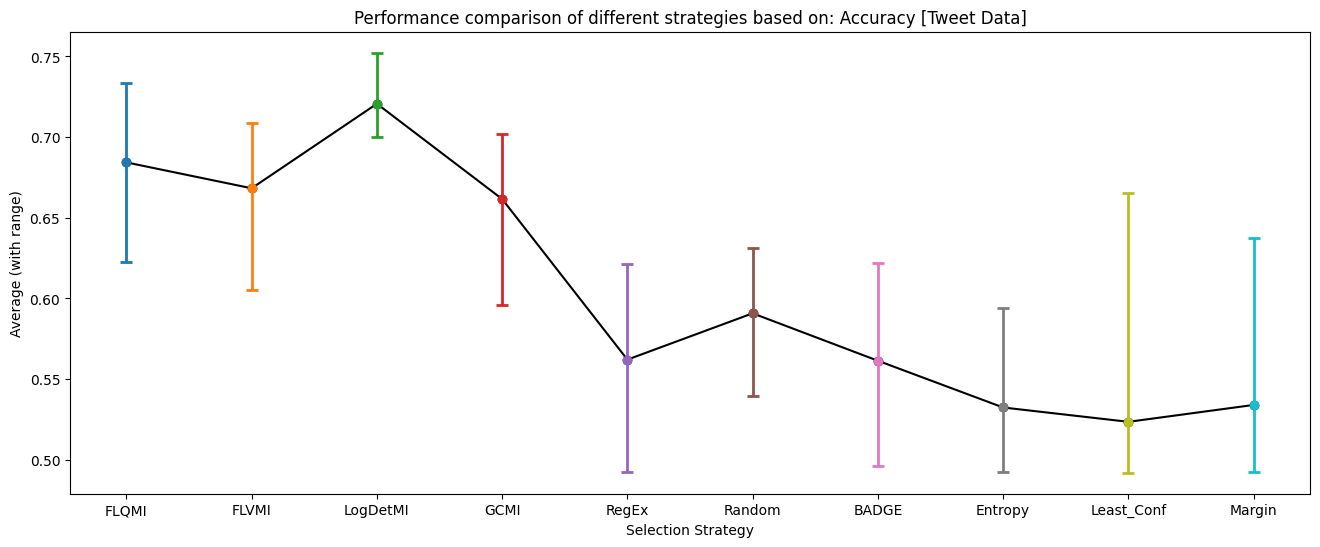

In [ ]:
graph_metric('acc')

### F-1 Score Graph

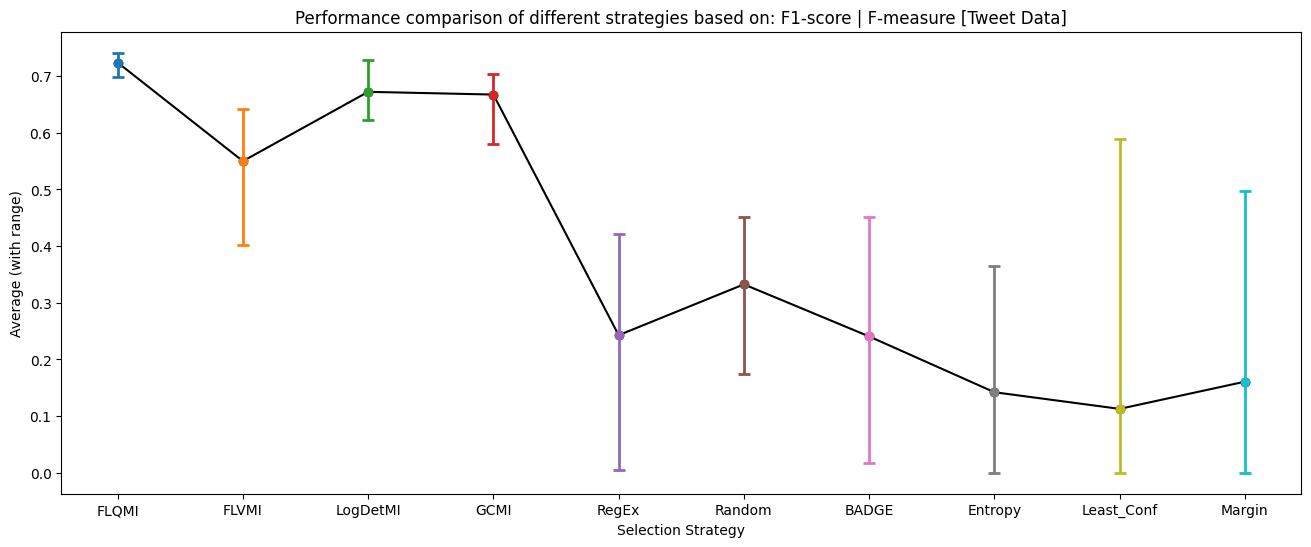

In [ ]:
graph_metric('f1')

### Precision Graphs

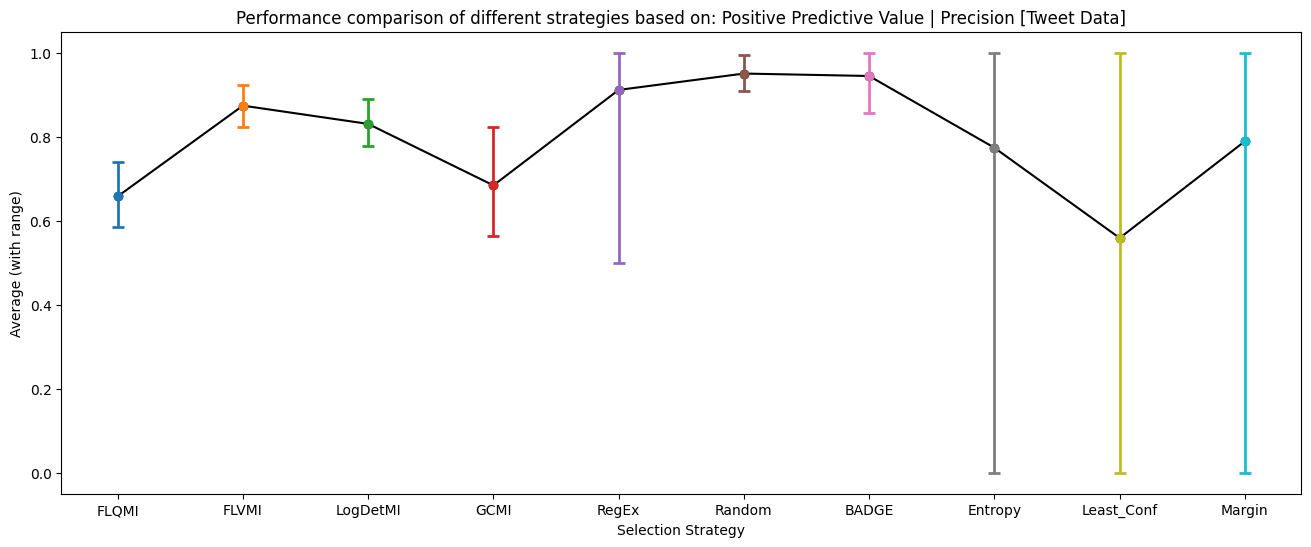

In [ ]:
graph_metric('ppv')

### Recall Graphs

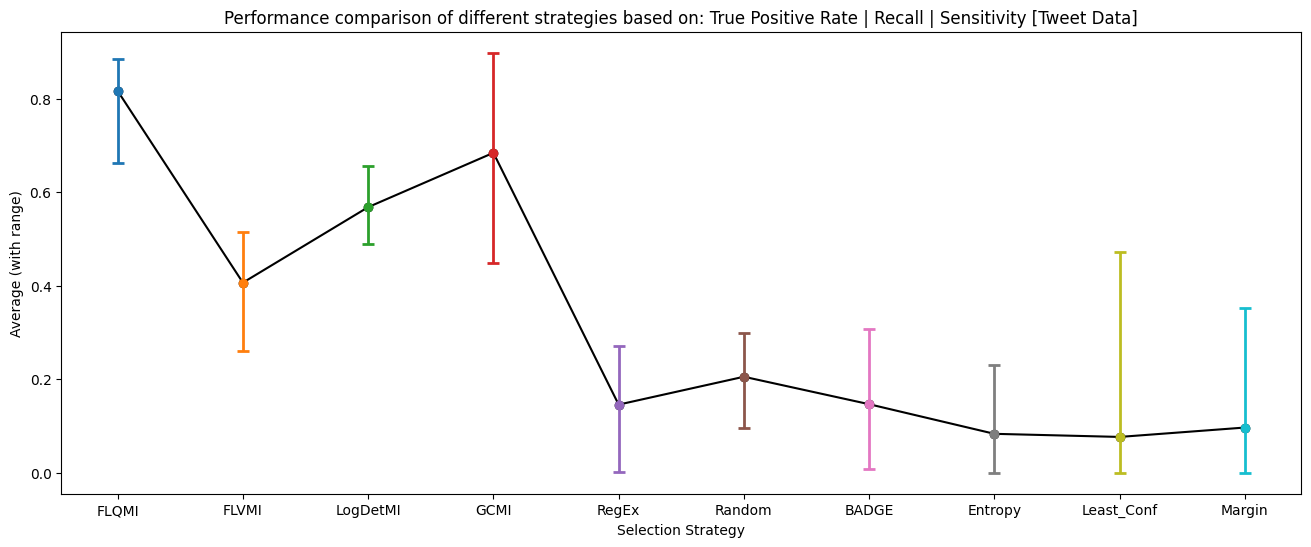

In [ ]:
graph_metric('tpr')

### Matthews Correlation Coefficient Graphs

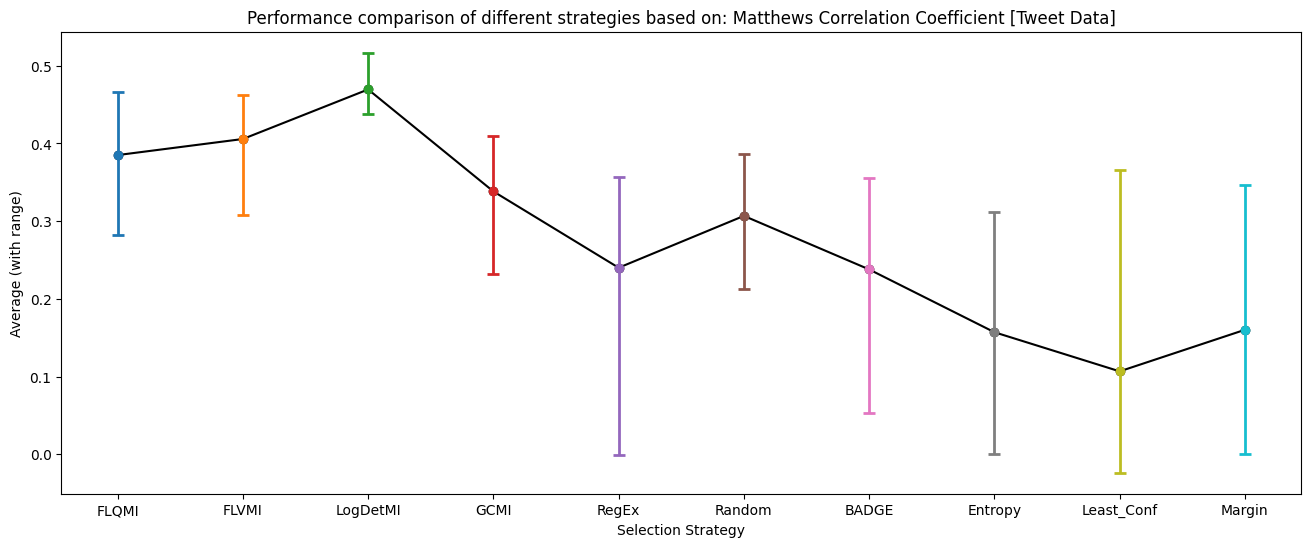

In [ ]:
graph_metric('mcc')

## Performance Graphs - Metric Variations

In [ ]:
def graph_variance(metric):

    data = Metric_stats[metric]

    # Extract data from the dictionary
    strategies = list(data.keys())
    averages = [data[strategy]['avg'] for strategy in strategies]
    std_devs = [data[strategy]['std_dev']/2 for strategy in strategies]
    colors = ['C{}'.format(i) for i in range(len(data))]  # One color for each strategy

    plt.figure(figsize=(16, 6))
    plt.bar(strategies, averages, yerr=std_devs, alpha = 0.3, capsize=5, color=colors)
    plt.xlabel('Selection Strategy')
    plt.ylabel('Average (with standard deviation)')
    plt.title('Variation in performance of different strategies based on: {} [Tweet Data]'.format(metric_dict[metric]))
    plt.show()

### Accuracy Variation

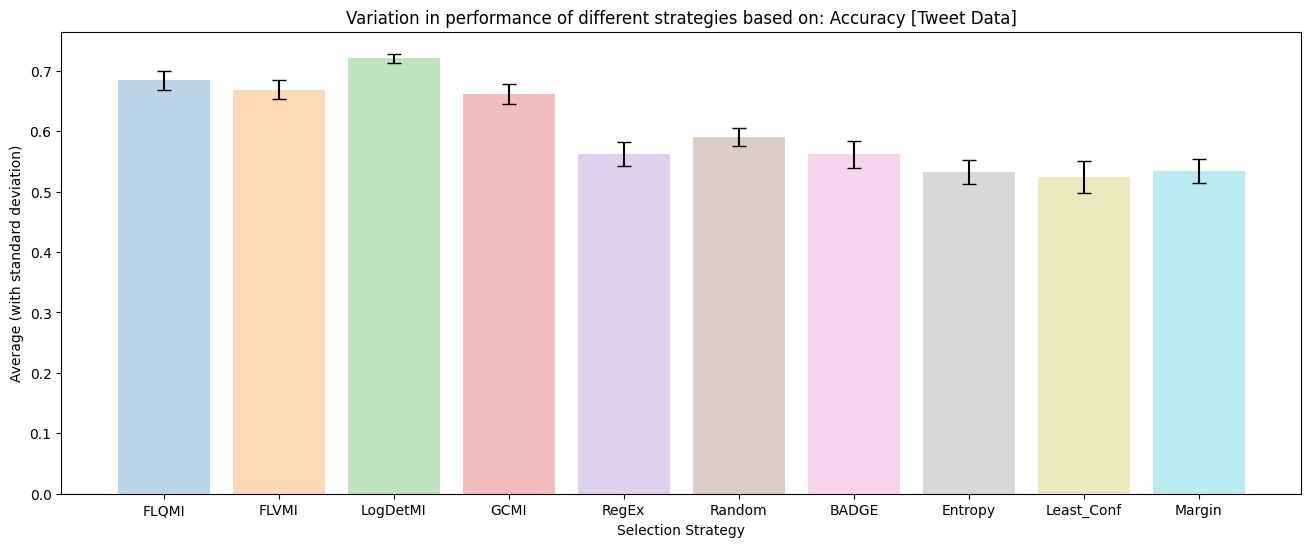

In [ ]:
graph_variance('acc')

### F1-Score Variation

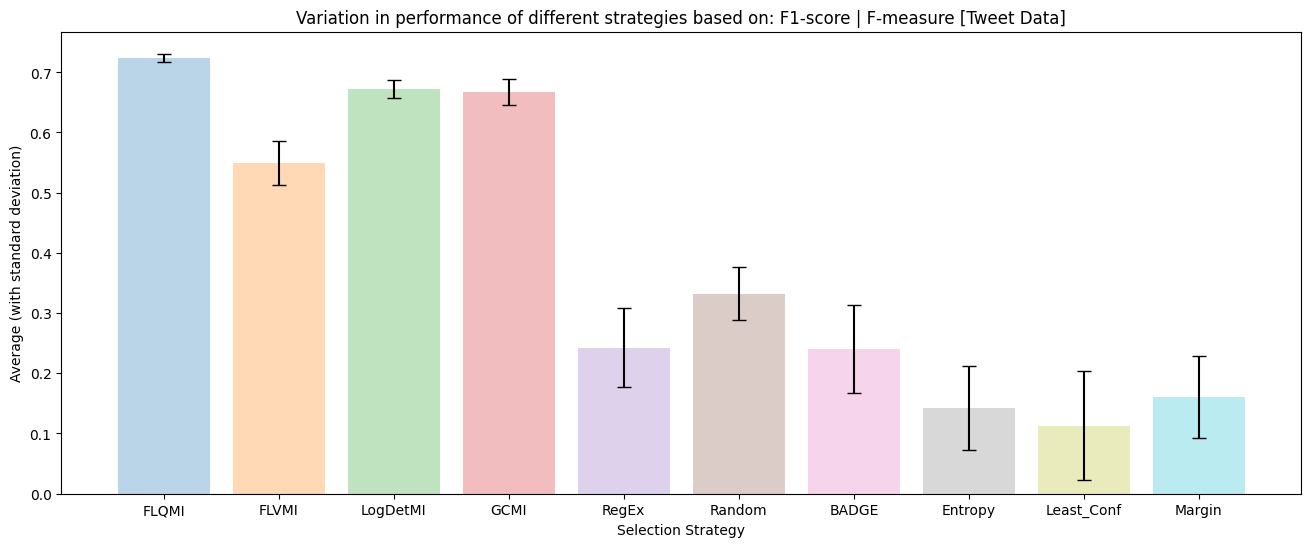

In [ ]:
graph_variance('f1')

### Precision Variation

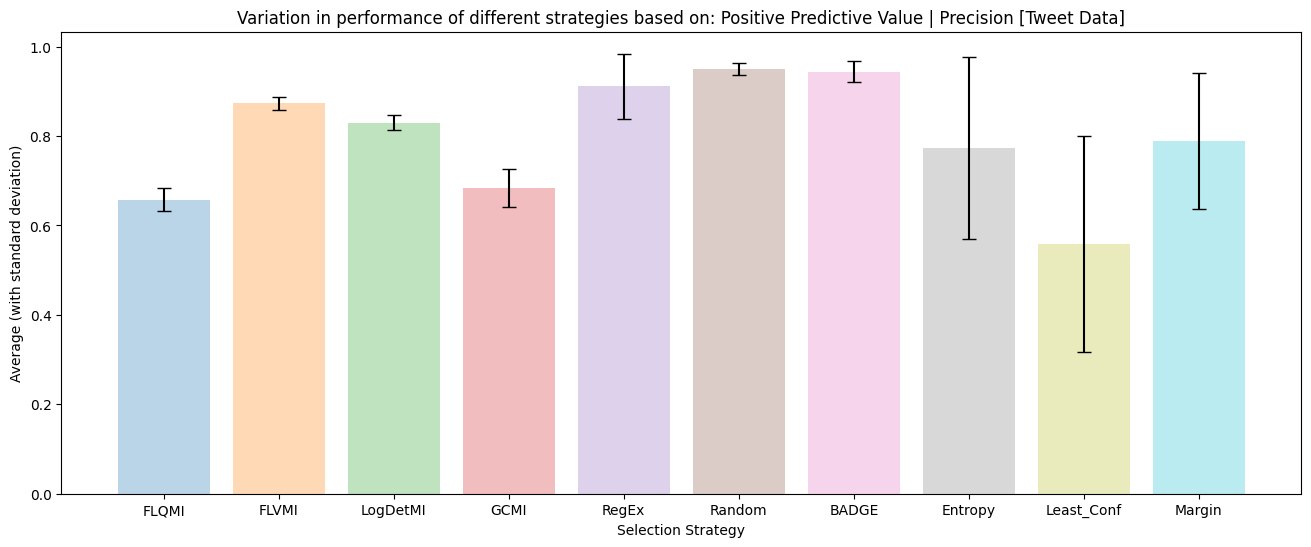

In [ ]:
graph_variance('ppv')

### Recall Variation

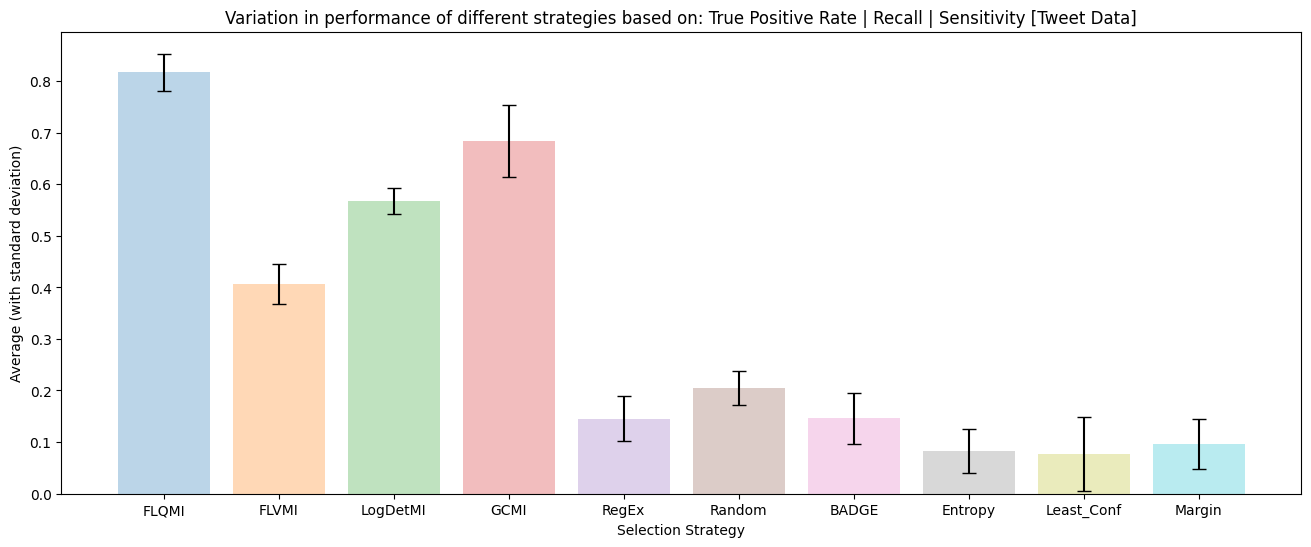

In [ ]:
graph_variance('tpr')

### Matthews Correlation Coefficient Variation

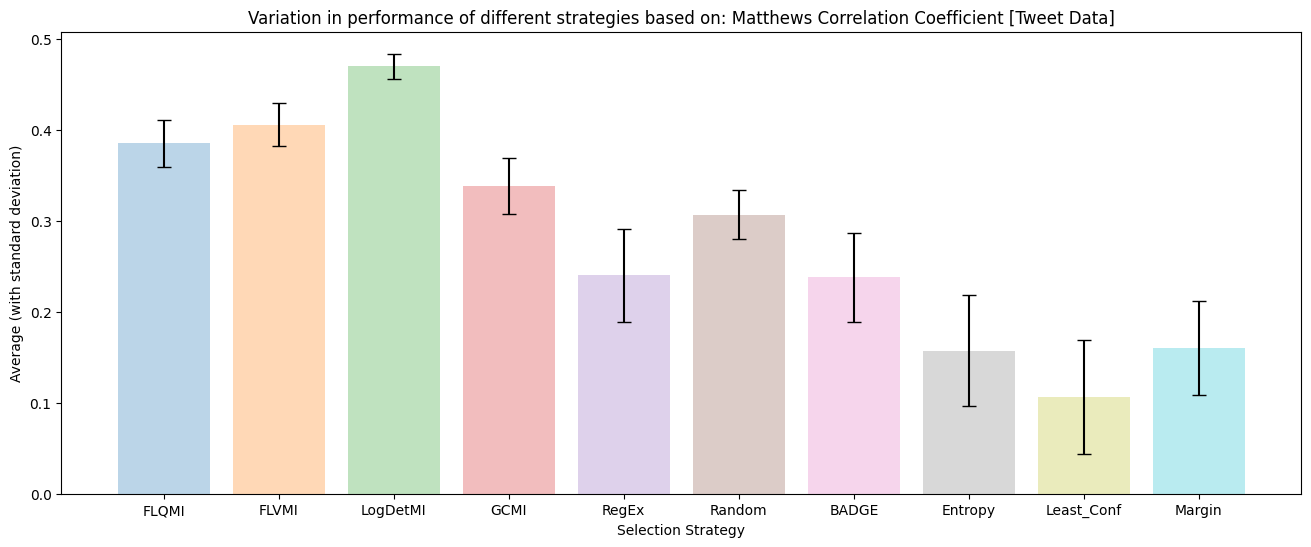

In [ ]:
graph_variance('mcc')